In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn.functional as F
import tqdm
import random

from torch import nn
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset

from vit_pytorch.vit import Transformer

In [27]:
ecg_mat = scipy.io.loadmat('ECGData.mat')

In [28]:
ecg_data = ecg_mat['ECGData'][0][0][0]
print(ecg_data.shape)

(162, 65536)


In [29]:
labels = ecg_mat['ECGData'][0][0][1]
print(labels.shape)

(162, 1)


In [30]:
def split_dataset_indices(N, train_percent, val_percent, test_percent, seed=42):
    # Validate input percentages
    if train_percent + val_percent + test_percent != 100:
        raise ValueError("The sum of the percentages must be 100.")

    random.seed(seed)
    # Generate a list of indices
    indices = list(range(N))
    random.shuffle(indices)

    # Calculate split sizes
    train_size = int((train_percent / 100) * N)
    val_size = int((val_percent / 100) * N)

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    return train_indices, val_indices, test_indices

In [31]:
train_indices, val_indices, test_indices = split_dataset_indices(labels.shape[0], 70, 15, 15)

In [32]:
def create_windowed_dataset(data, labels, window_size=1024, stride=None):
    if not stride:
        stride = window_size

    min_val = np.min(data, axis=(0, 1), keepdims=True)
    max_val = np.max(data, axis=(0, 1), keepdims=True)
    data = 2 * ((data - min_val) / (max_val - min_val)) - 1
    
    num_samples, sample_size = data.shape
    num_windows = sample_size // window_size
    
    # Initialize the windowed data and label arrays
    windowed_data = np.empty((num_samples * num_windows, window_size))
    windowed_labels = np.empty((num_samples * num_windows, 1), dtype=labels.dtype)

    for i in range(num_samples):
        for j in range(num_windows):
            start = j * stride
            end = start + window_size
            windowed_data[i * num_windows + j, :] = data[i, start:end]
            windowed_labels[i * num_windows + j, :] = labels[i]

    return torch.tensor(np.expand_dims(windowed_data, 1), dtype=torch.float32), windowed_labels

In [33]:
ecg_t, labels_t = create_windowed_dataset(ecg_data[train_indices], labels[train_indices], window_size=1024)
ecg_v, labels_v = create_windowed_dataset(ecg_data[val_indices], labels[val_indices], window_size=1024)

In [34]:
ecg_t.shape

torch.Size([7232, 1, 1024])

In [35]:
ecg_v.shape

torch.Size([1536, 1, 1024])

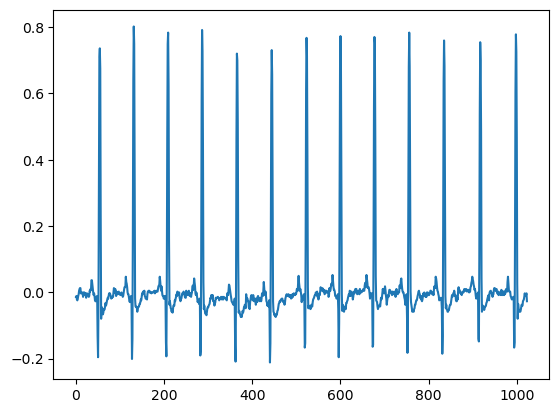

In [36]:
plt.plot(ecg_v[0, 0])

In [66]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height = image_size
        patch_height = patch_size 

        assert image_height % patch_height == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height)
        patch_dim = channels * patch_height
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) -> b h (p1 c)', p1 = patch_height),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [67]:
v = ViT(
    image_size = 1024,
    patch_size = 64,
    num_classes = 10,
    dim = 128,
    depth = 12,
    heads = 8,
    mlp_dim = 256,
    channels = 1
)

In [68]:
ecg_v.shape

torch.Size([1536, 1, 1024])

In [69]:
emb_ex = v.to_patch_embedding(ecg_v)
emb_ex.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (24576x360 and 64x128)

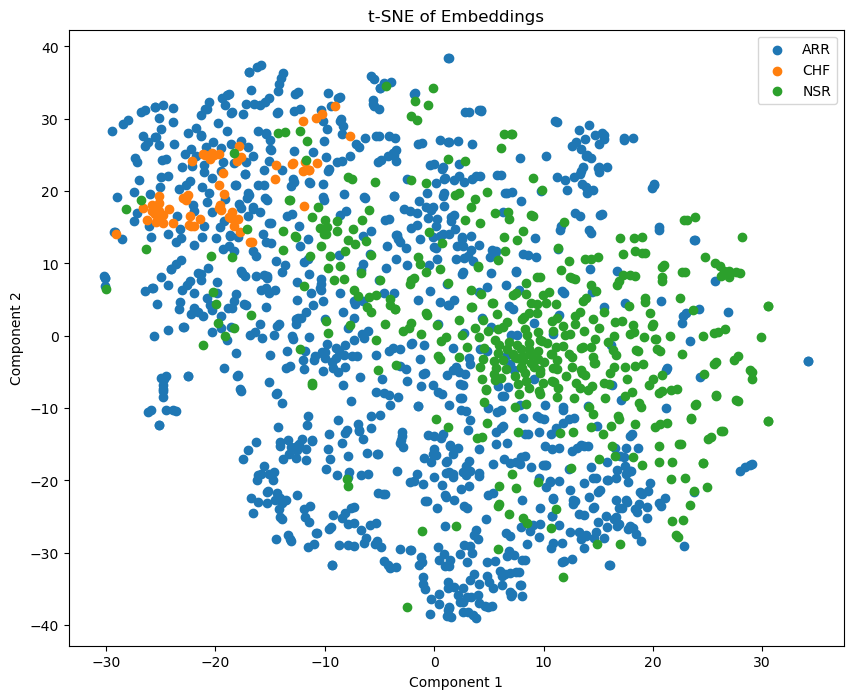

In [40]:
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming logits and labels are already defined
# Convert logits to numpy array for compatibility with scikit-learn
logits_np = emb_ex.detach().numpy().mean(axis=1)

# Flatten the nested structure of labels
labels_flattened = np.array([label[0][0] for label in labels_v])

# Encode the string labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_flattened)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
logits_2d = tsne.fit_transform(logits_np)

# Plot
plt.figure(figsize=(10, 8))

# Scatter plot for each unique label to create a legend
unique_labels = np.unique(labels_flattened)
for label in unique_labels:
    idx = labels_flattened == label
    plt.scatter(logits_2d[idx, 0], logits_2d[idx, 1], label=label)

plt.title('t-SNE of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

# CHF = congestive heart failure

In [16]:
class MAE(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        masking_ratio = 0.75,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'
        self.masking_ratio = masking_ratio

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)

        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]

        print(f'num_patches: {num_patches}')
        print(f'encoder_dim: {encoder_dim}')

        self.to_patch = encoder.to_patch_embedding[0]
        self.patch_to_emb = nn.Sequential(*encoder.to_patch_embedding[1:])

        pixel_values_per_patch = encoder.to_patch_embedding[2].weight.shape[-1]
        print(f'pixel_values_per_patch: {pixel_values_per_patch}')

        # decoder parameters
        self.decoder_dim = decoder_dim
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        device = img.device

        # get patches

        patches = self.to_patch(img)
        #print(f'patches: {patches.shape}')
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions

        tokens = self.patch_to_emb(patches)
        if self.encoder.pool == "cls":
            tokens += self.encoder.pos_embedding[:, 1:(num_patches + 1)]
        elif self.encoder.pool == "mean":
            tokens += self.encoder.pos_embedding.to(device, dtype=tokens.dtype) 

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]
        
        #print(f'num masked: {num_masked}')
        
        # get the unmasked tokens to be encoded

        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss

        masked_patches = patches[batch_range, masked_indices]
        #print(f'masked_patches: {masked_patches.shape}')

        # attend with vision transformer

        encoded_tokens = self.encoder.transformer(tokens)
        #print(f'encoded_tokens: {encoded_tokens.shape}')

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder

        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens

        unmasked_decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder
        
        decoder_tokens = torch.zeros(batch, num_patches, self.decoder_dim, device=device)
        decoder_tokens[batch_range, unmasked_indices] = unmasked_decoder_tokens
        decoder_tokens[batch_range, masked_indices] = mask_tokens
        decoded_tokens = self.decoder(decoder_tokens)
        #print(f'decoded_tokens: {encoded_tokens.shape}')

        # splice out the mask tokens and project to pixel values

        mask_tokens = decoded_tokens[batch_range, masked_indices]
        pred_pixel_values = self.to_pixels(mask_tokens)
        #print(f'pred_pixel_values: {pred_pixel_values.shape}')

        mse = (masked_patches - pred_pixel_values) ** 2

        # calculate reconstruction loss

        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss, patches.detach().numpy(), masked_indices.detach().numpy(), pred_pixel_values.detach().numpy()

In [17]:
mae = MAE(
    encoder = v,
    masking_ratio = 0.25,   # the paper recommended 75% masked patches
    decoder_dim = 128,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

loss, patches, masked_indices, pred_pixel_values = mae(ecg_t[:1])
print(loss)

num_patches: 17
encoder_dim: 128
pixel_values_per_patch: 64
tensor(0.6294, grad_fn=<MseLossBackward0>)


In [18]:
print('masked_indices:')
print(masked_indices.shape)

print('patches:')
print(patches.shape)

print('pred_pixel_values:')
print(pred_pixel_values.shape)

masked_indices:
(1, 4)
patches:
(1, 16, 64)
pred_pixel_values:
(1, 4, 64)


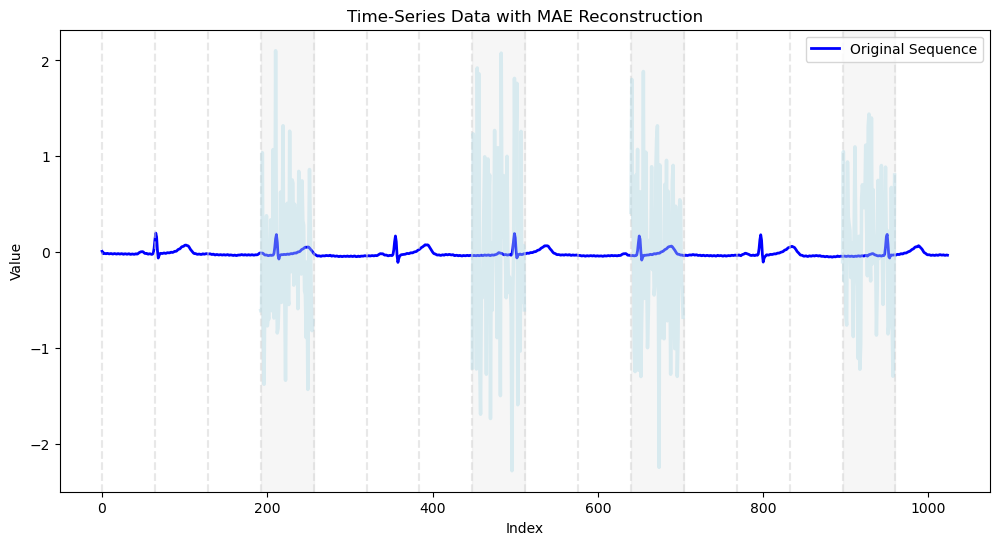

In [19]:
# Example for one sequence (index 0)

def plot_example(patches, masked_indices, pred_pixel_values, sequence_index):
    original_sequence = patches[sequence_index].reshape(-1)  # Reshape to 1D
    masked_patches = masked_indices[sequence_index]
    reconstructed_patches = pred_pixel_values[sequence_index]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(original_sequence, label='Original Sequence', color='blue', linewidth=2)

    seq_len = patches.shape[1] * patches.shape[2]
    patch_size = patches.shape[2]
    
    # Subtle patch boundaries
    for i in range(0, seq_len, patch_size):
        plt.axvline(x=i, color='lightgray', linestyle='--', alpha=0.5)
    
    # Subtle background for masked areas
    for idx in masked_patches:
        plt.axvspan(idx * patch_size, (idx + 1) * patch_size, color='lightgray', alpha=0.2)
    
    # Show reconstructed patches (assuming they're in the same order as masked_indices)
    for i, idx in enumerate(masked_patches):
        reconstructed_section = reconstructed_patches[i].reshape(-1)
        plt.plot(range(idx * patch_size, (idx + 1) * patch_size), reconstructed_section, color='lightblue', linewidth=2.5, alpha=0.4)
    
    plt.legend()
    plt.title('Time-Series Data with MAE Reconstruction')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

plot_example(patches, masked_indices, pred_pixel_values, 0)

In [23]:
# Function to create batches - returns a DataLoader
def create_batches(data, batch_size):
    tensor_data = torch.Tensor(data)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to determine the tqdm environment
def get_tqdm():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return tqdm_notebook.tqdm
        else:
            return tqdm.tqdm
    except NameError:
        return tqdm.tqdm

# Training loop
def train_model(train_data, val_data, batch_size, num_epochs, model, optimizer):
    # Use the appropriate tqdm version
    tqdm_bar = get_tqdm()

    # Create batches
    dataloader = create_batches(train_data, batch_size)

    for epoch in range(num_epochs):
        total_loss, num_batches = 0, 0
        with tqdm_bar(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for data_batch in dataloader:
                loss, _, _, _ = mae(data_batch[0])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                average_loss = total_loss / num_batches
                pbar.set_postfix(avg_loss=average_loss)
                pbar.update()
            with torch.no_grad():
                loss_v, patches_v, masked_indices_v, pred_pixel_values_v = mae(val_data)
                plot_example(patches_v, masked_indices_v, pred_pixel_values_v, 0)
                pbar.set_postfix(train_loss=average_loss, val_loss=loss_v.detach().numpy())

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:06<00:00,  1.36s/it, avg_loss=0.00554]

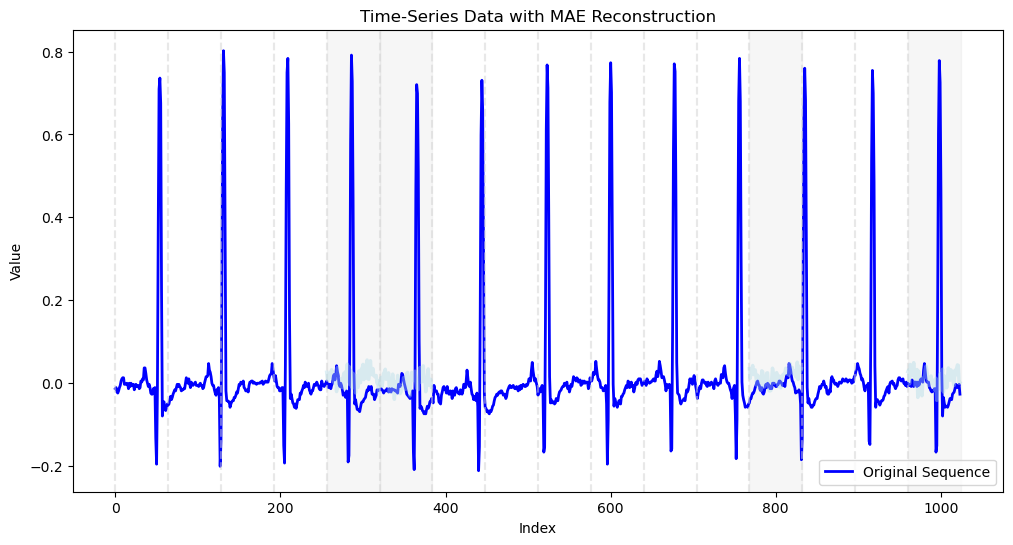

Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:45<00:00,  1.19s/it, avg_loss=0.00417]

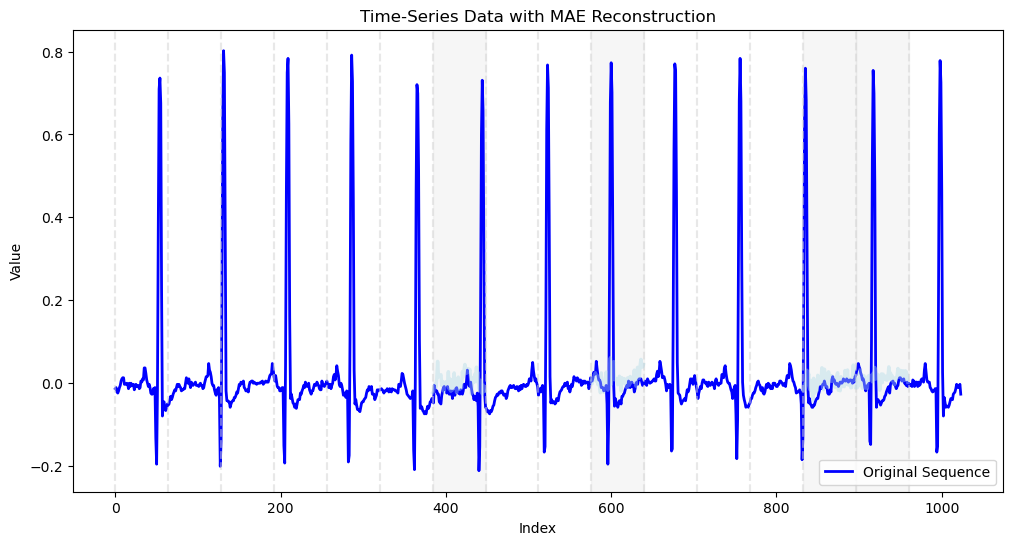

Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:29<00:00,  1.22s/it, avg_loss=0.00394]

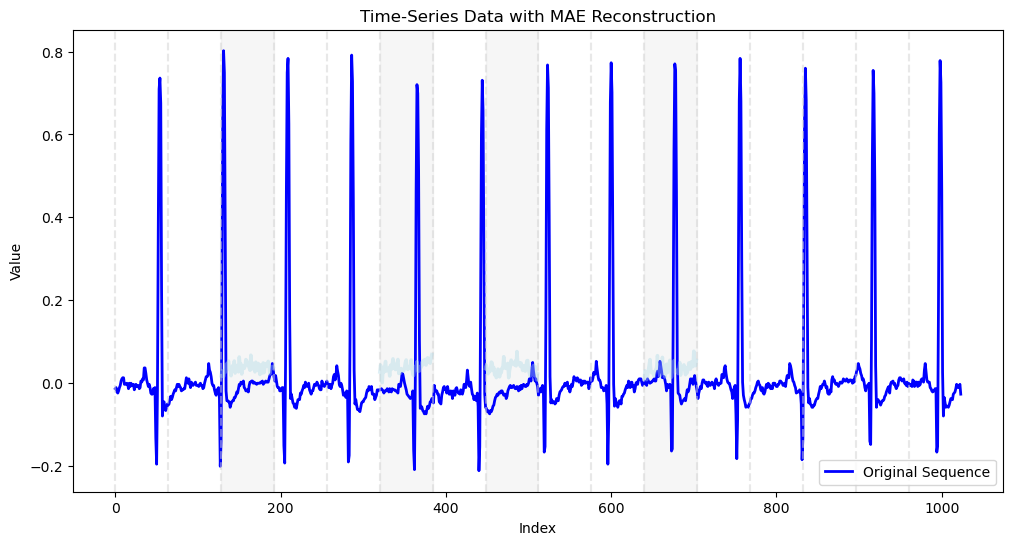

Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:45<00:00,  1.09s/it, avg_loss=0.00399]

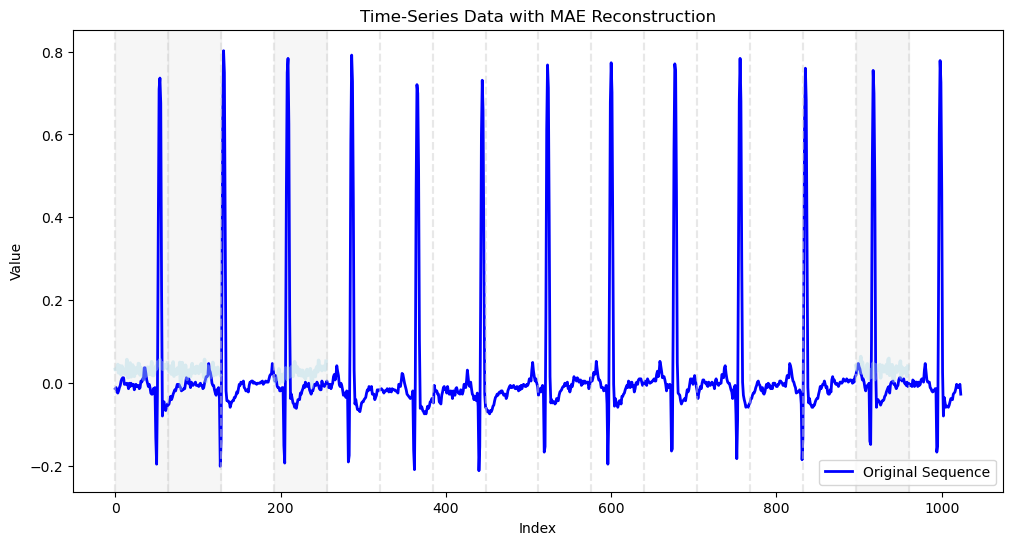

Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:46<00:00,  1.16s/it, avg_loss=0.00375]

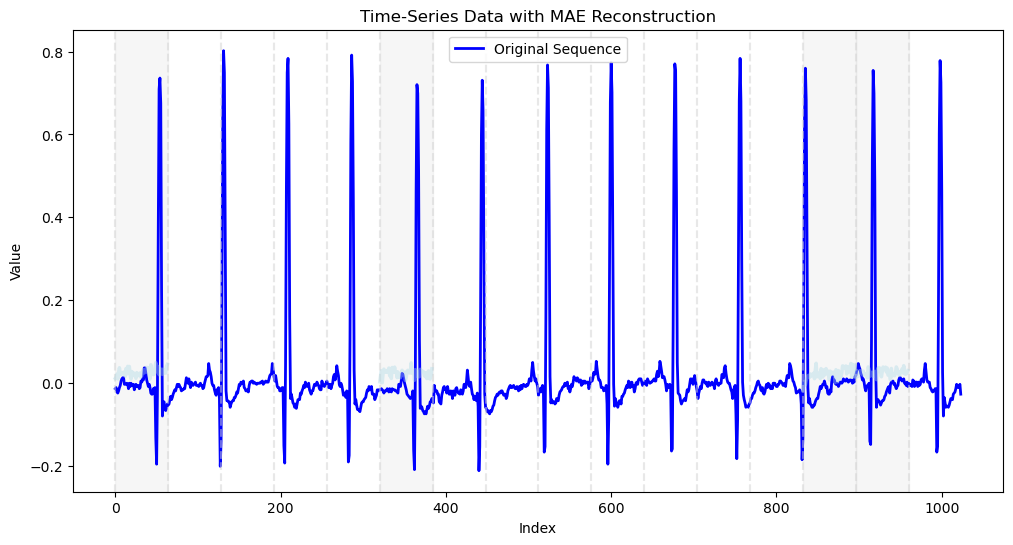

Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:35<00:00,  1.00it/s, avg_loss=0.00375]

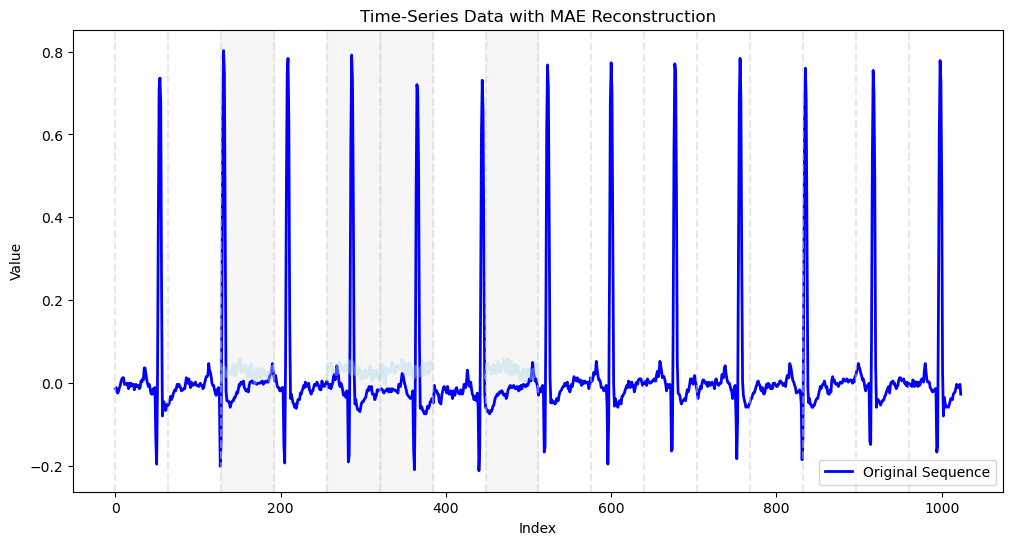

Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:13<00:00,  1.22s/it, avg_loss=0.00356]

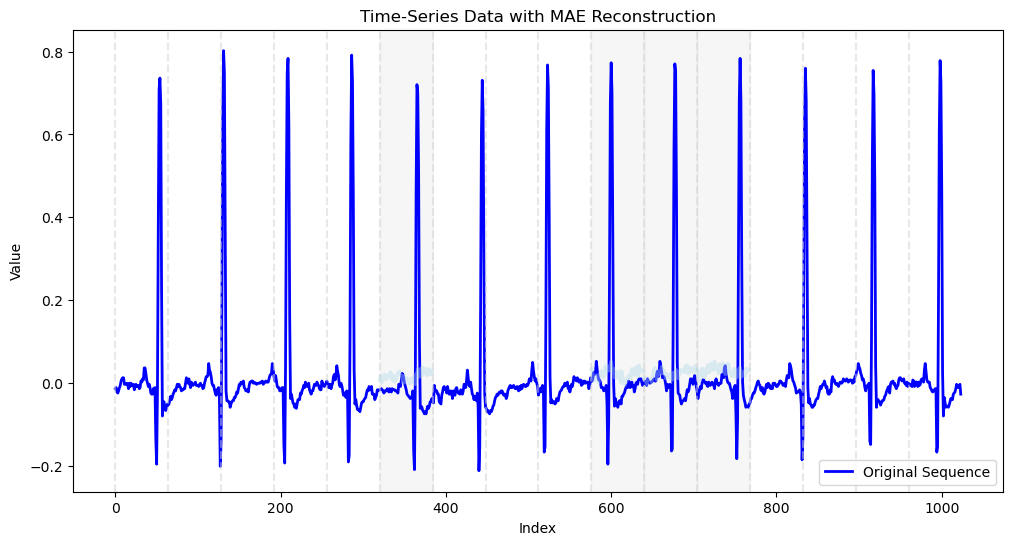

Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:33<00:00,  1.24s/it, avg_loss=0.00346]

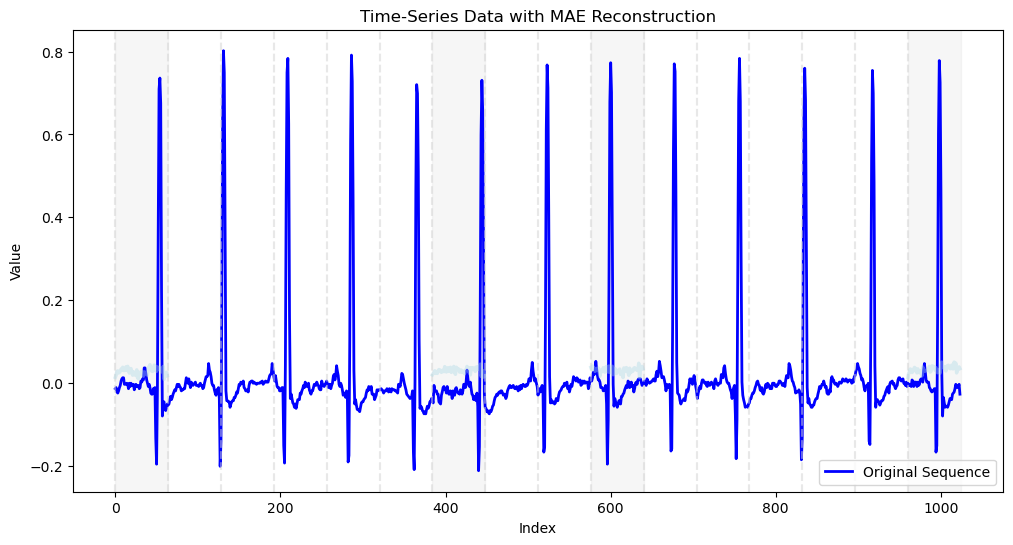

Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:35<00:00,  1.08s/it, avg_loss=0.00346]

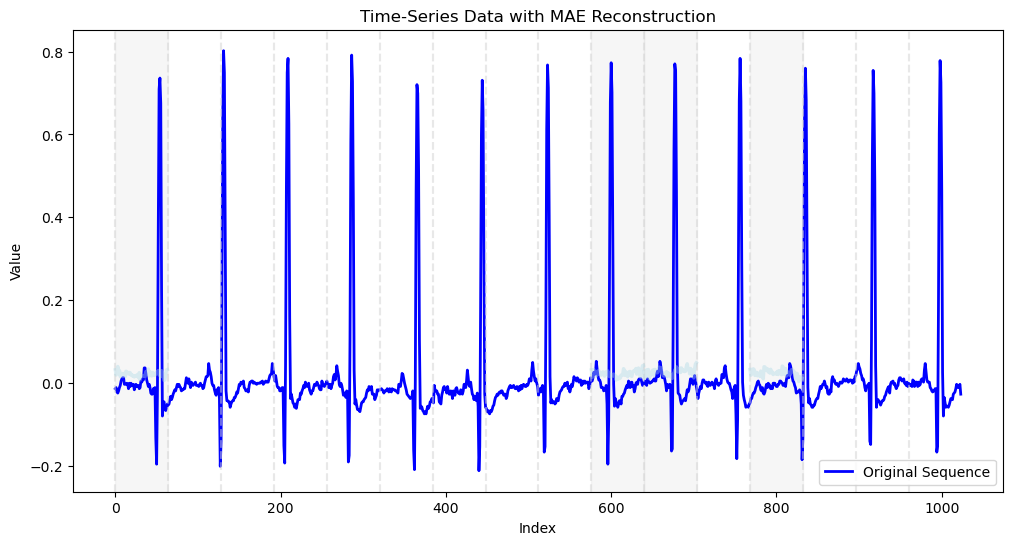

Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [07:43<00:00,  1.83s/it, avg_loss=0.00344]

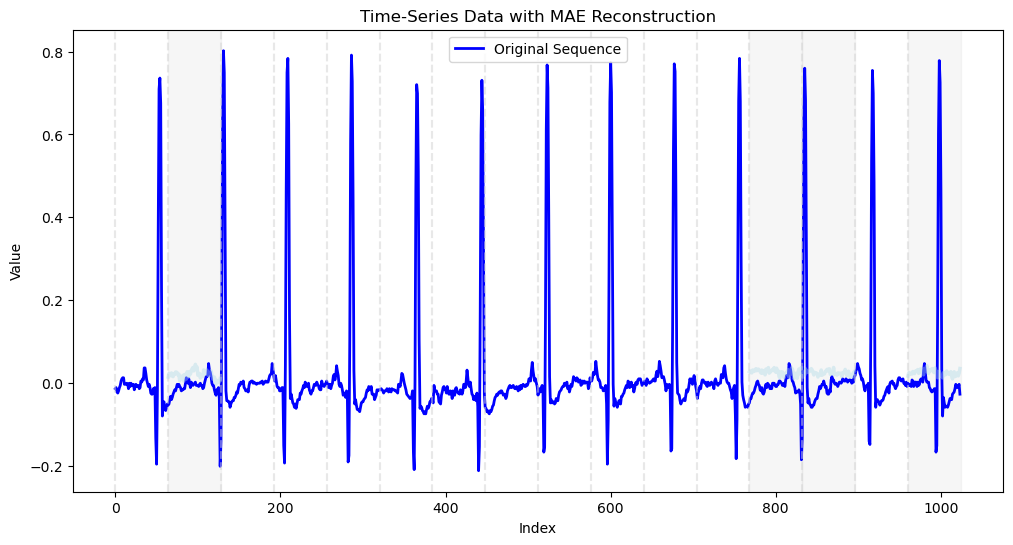

Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:53<00:00,  1.71s/it, avg_loss=0.00348]

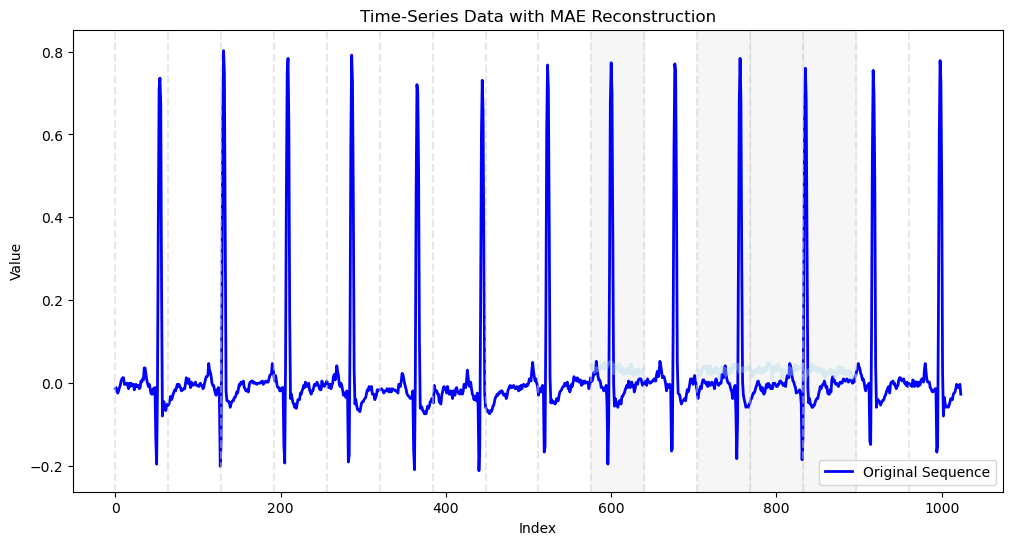

Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:28<00:00,  1.50s/it, avg_loss=0.00346]

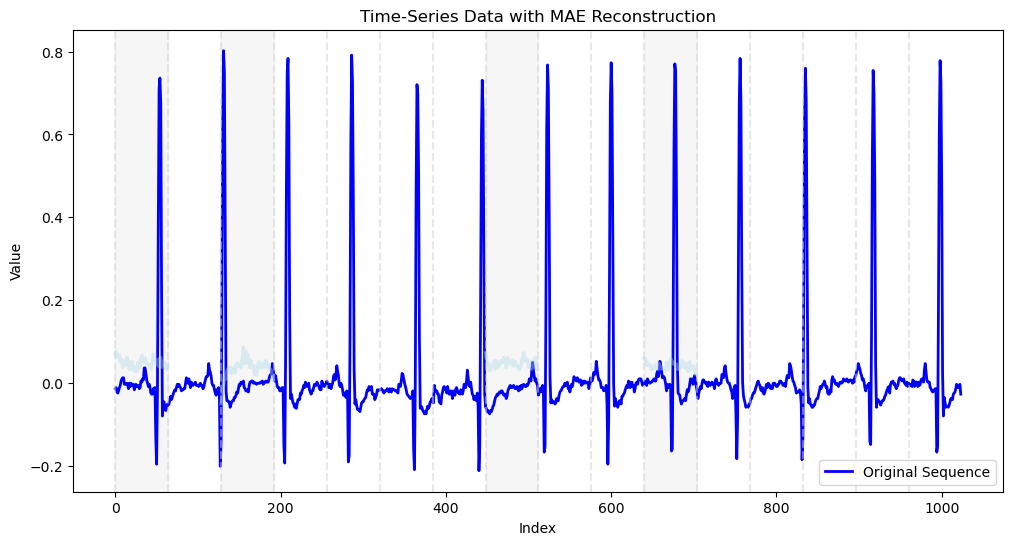

Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:06<00:00,  1.60s/it, avg_loss=0.00345]

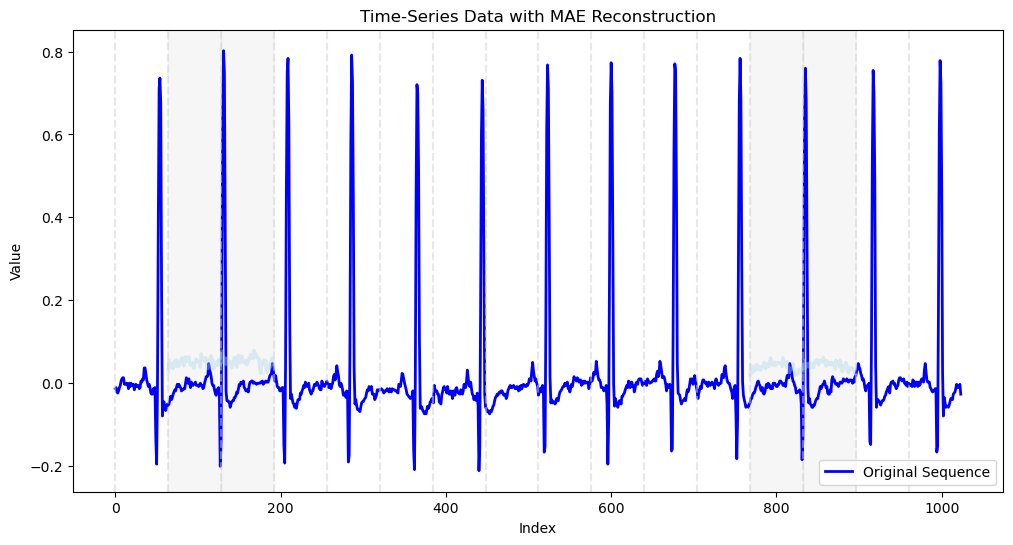

Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:54<00:00,  1.57s/it, avg_loss=0.00344]

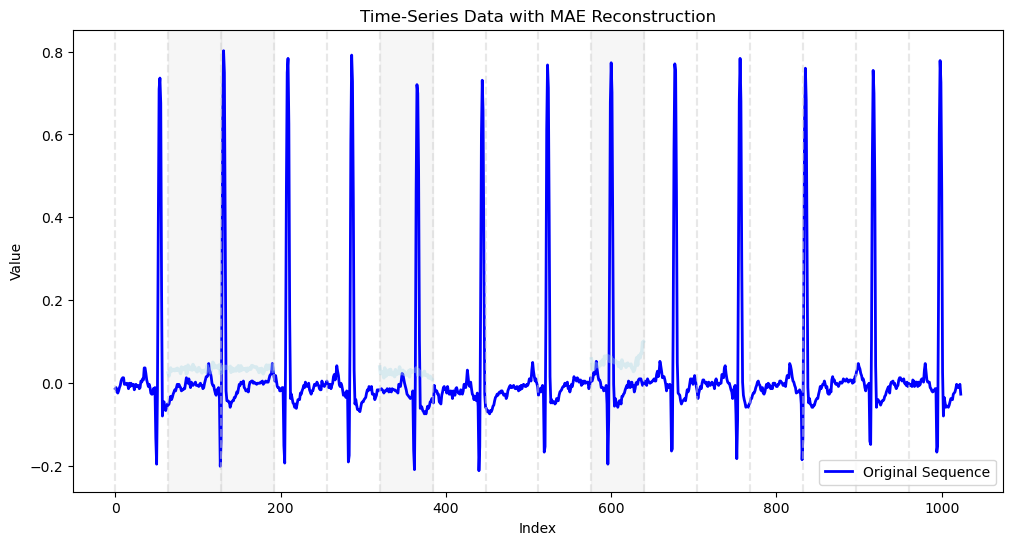

Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:10<00:00,  1.22s/it, avg_loss=0.00321]

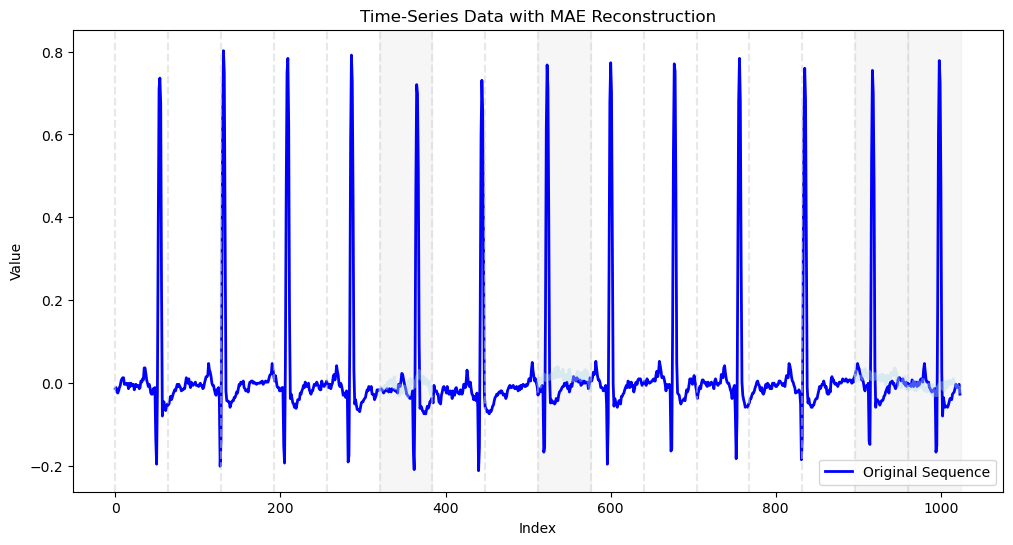

Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:19<00:00,  1.56s/it, avg_loss=0.00336]

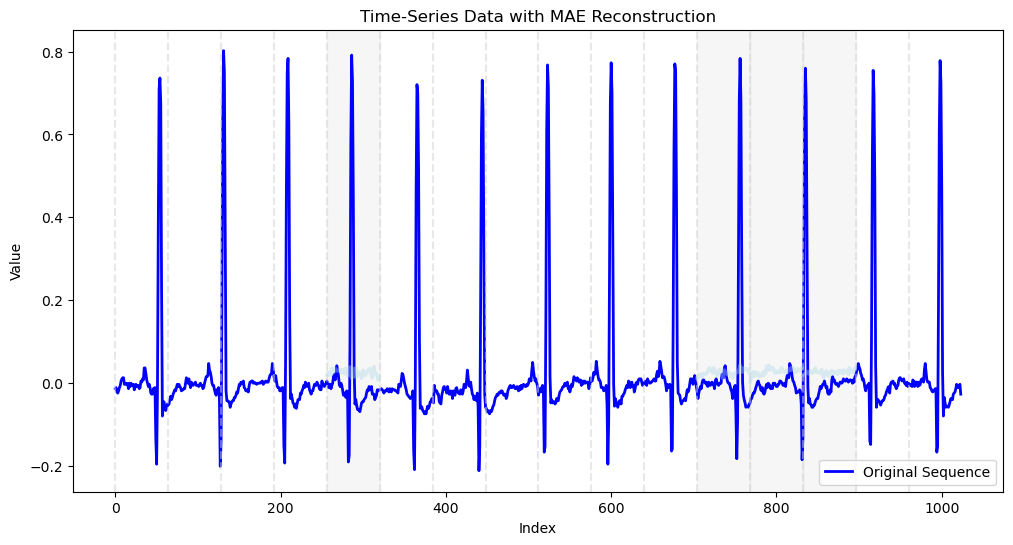

Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:22<00:00,  1.52s/it, avg_loss=0.00345]

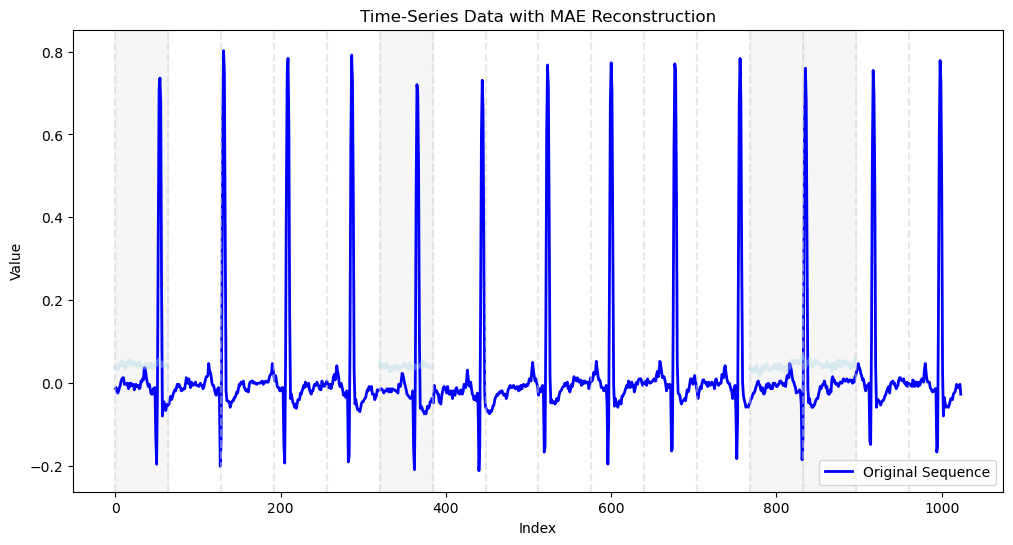

Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:22<00:00,  2.35s/it, avg_loss=0.0033]

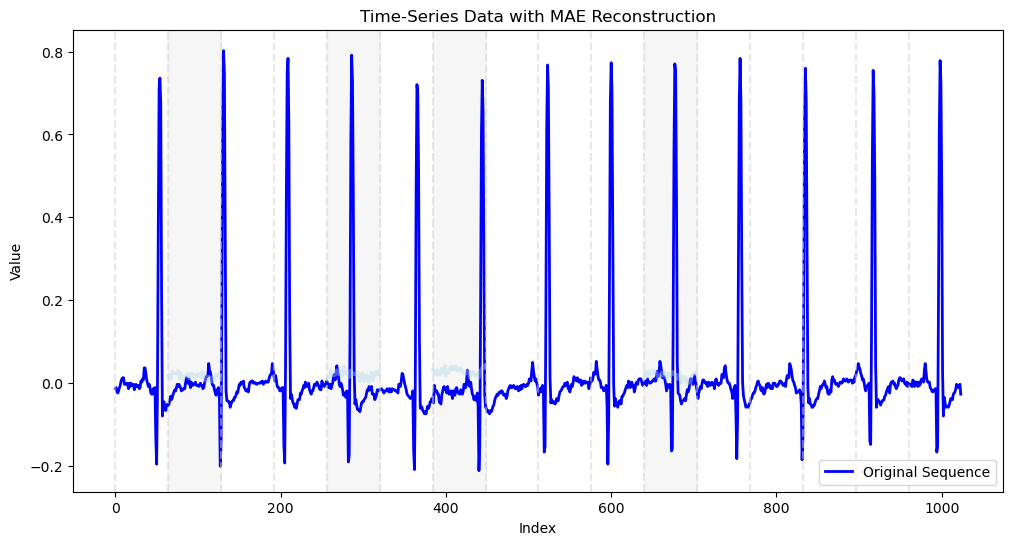

Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:01<00:00,  1.34s/it, avg_loss=0.00334]

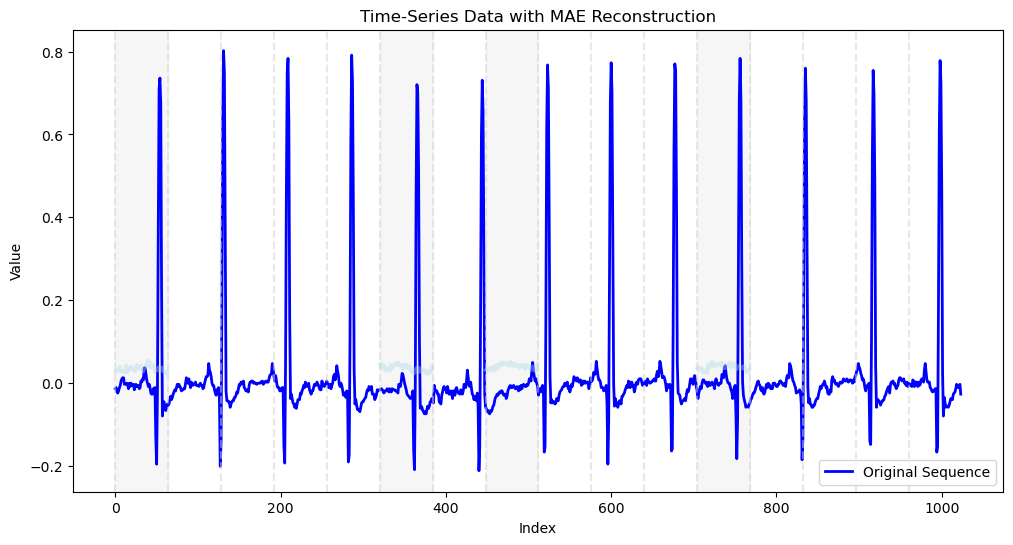

Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:47<00:00,  1.39s/it, avg_loss=0.0033]

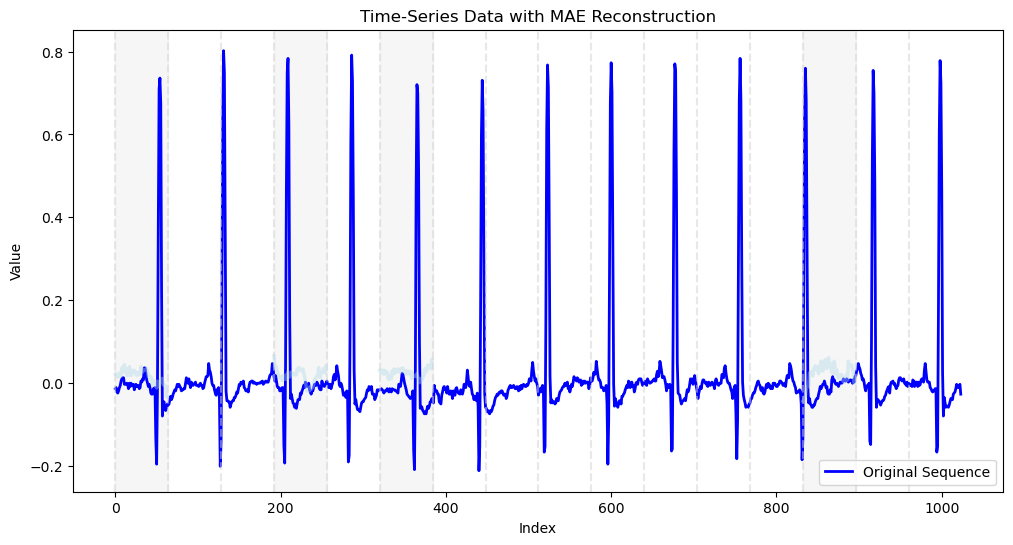

Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:16<00:00,  1.64s/it, avg_loss=0.0032]

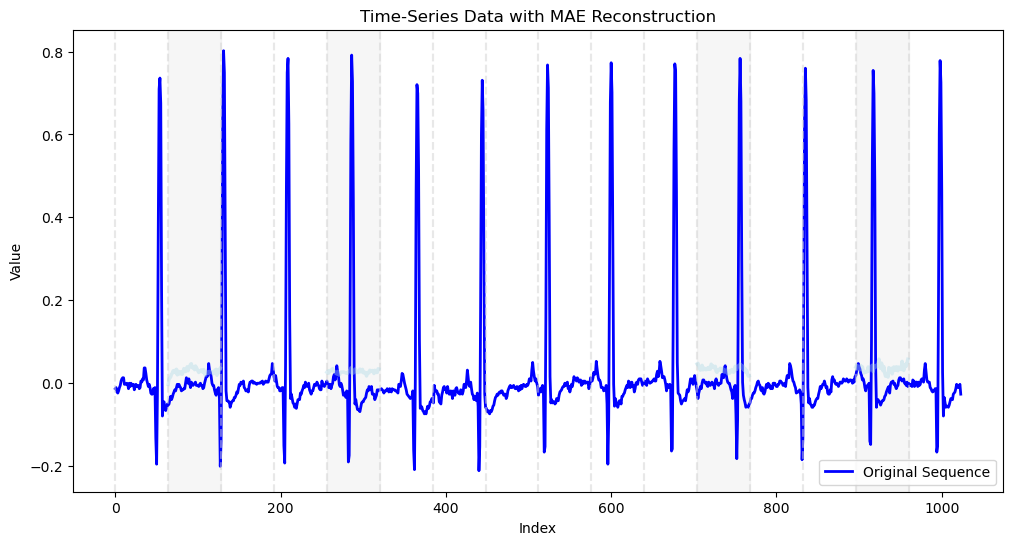

Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:14<00:00,  1.51s/it, avg_loss=0.00319]

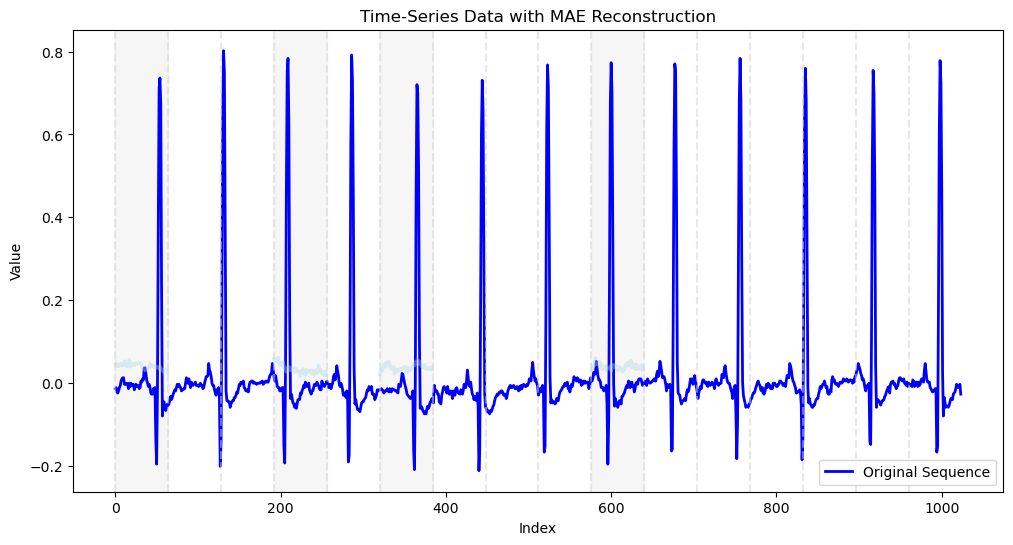

Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:16<00:00,  1.48s/it, avg_loss=0.00319]

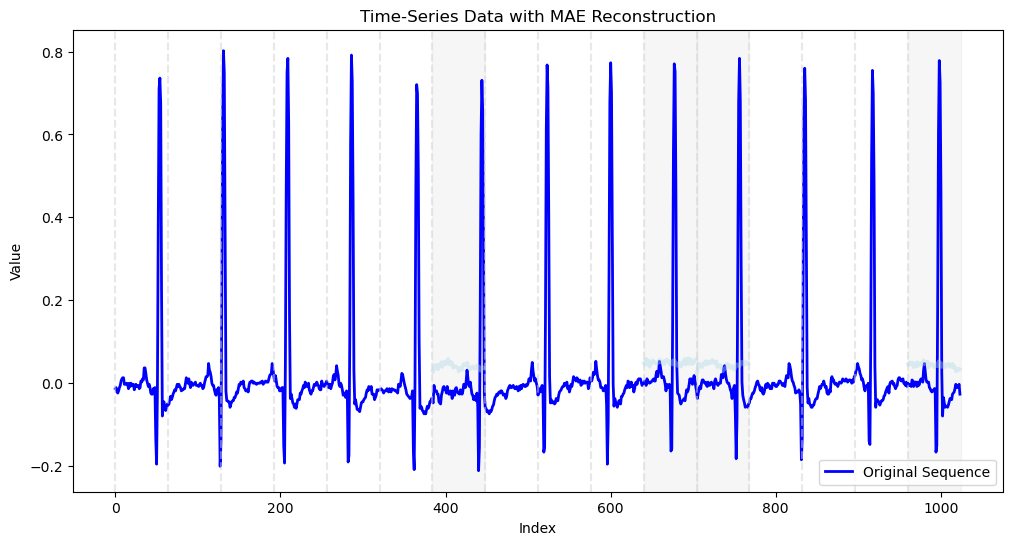

Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:22<00:00,  1.66s/it, avg_loss=0.00317]

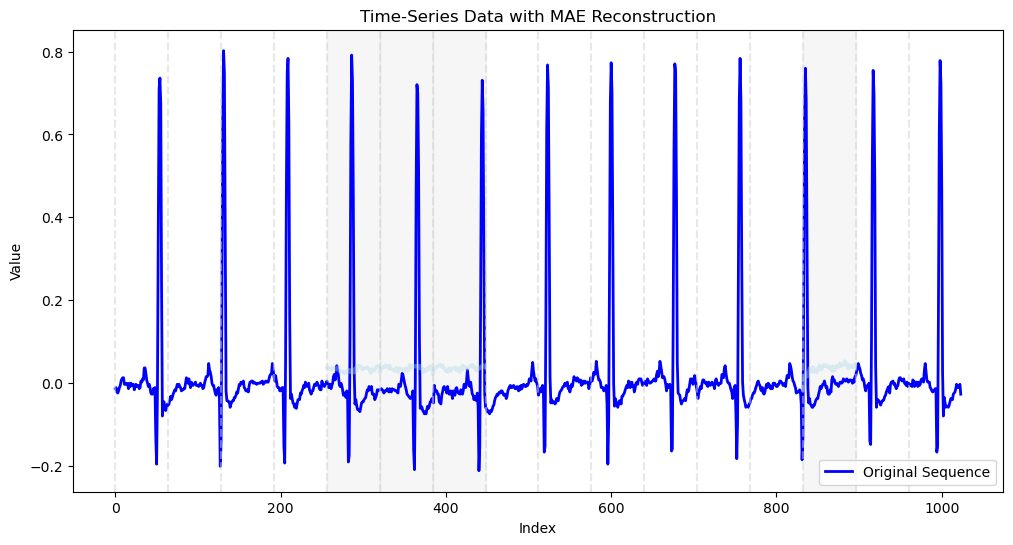

Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:04<00:00,  1.48s/it, avg_loss=0.00305]

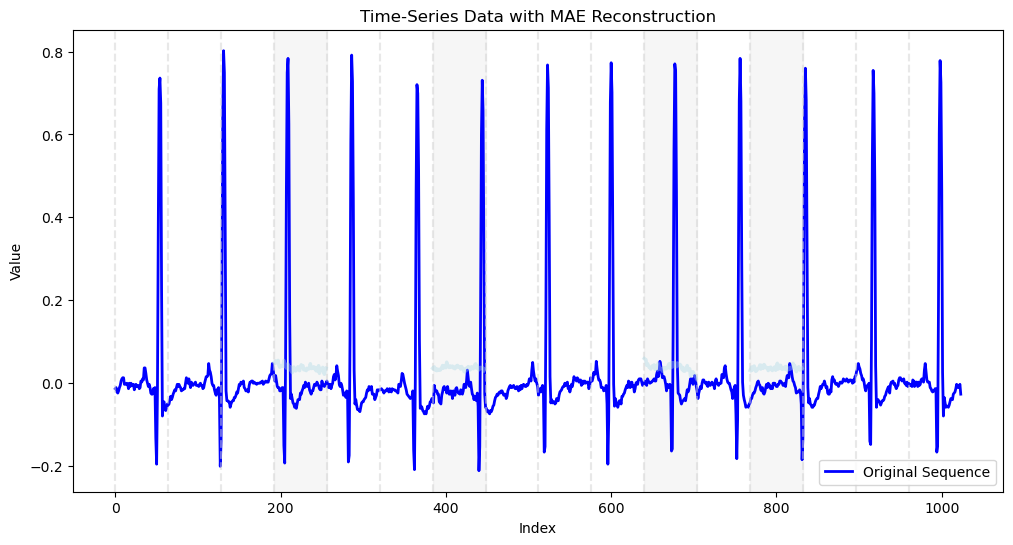

Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:51<00:00,  1.18s/it, avg_loss=0.00303]

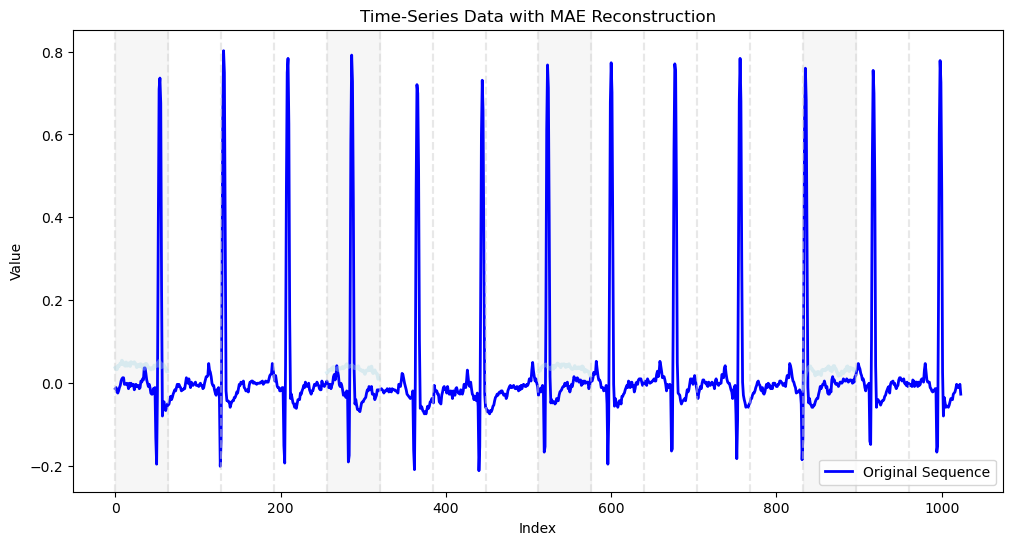

Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:41<00:00,  1.56s/it, avg_loss=0.00302]

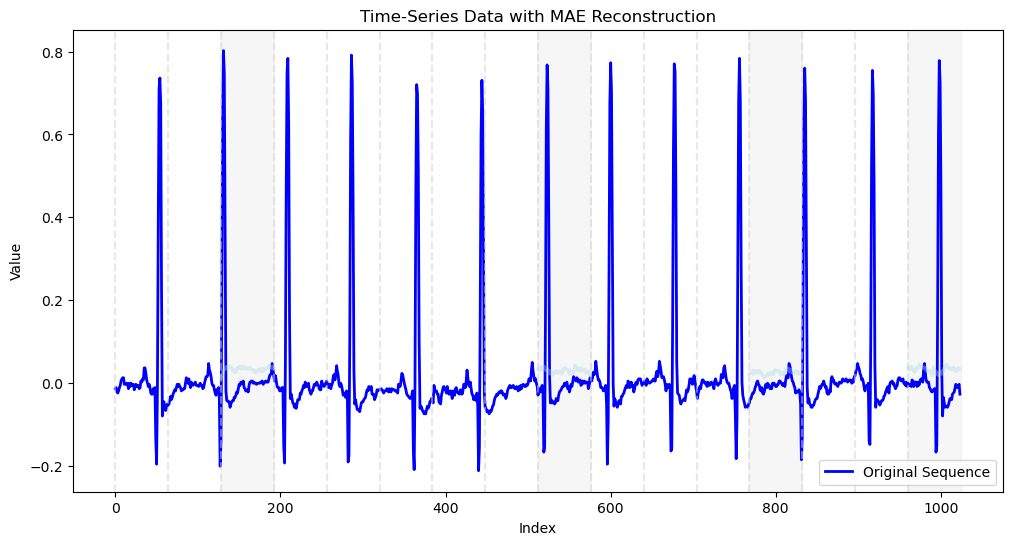

Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:24<00:00,  1.56s/it, avg_loss=0.00298]

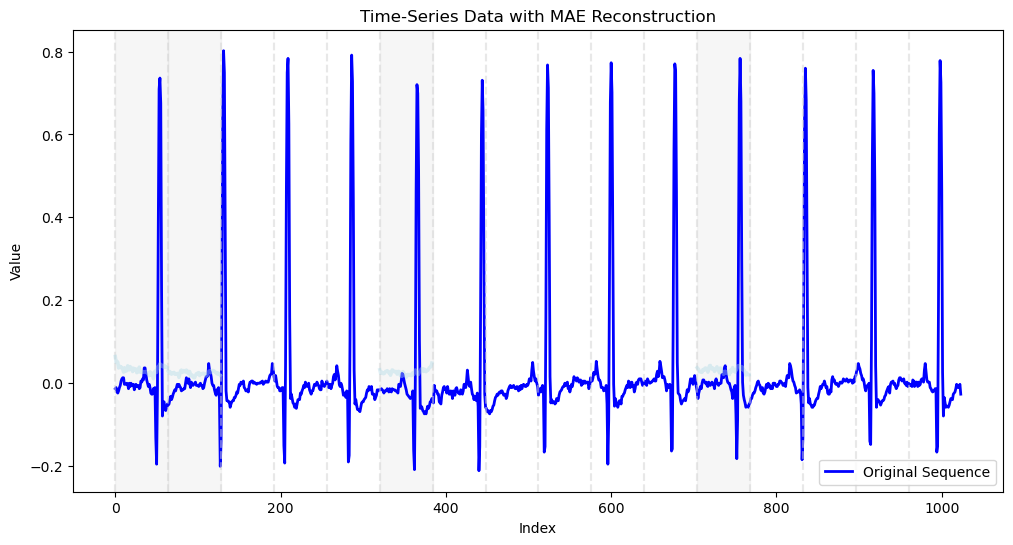

Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [05:56<00:00,  1.59s/it, avg_loss=0.00289]

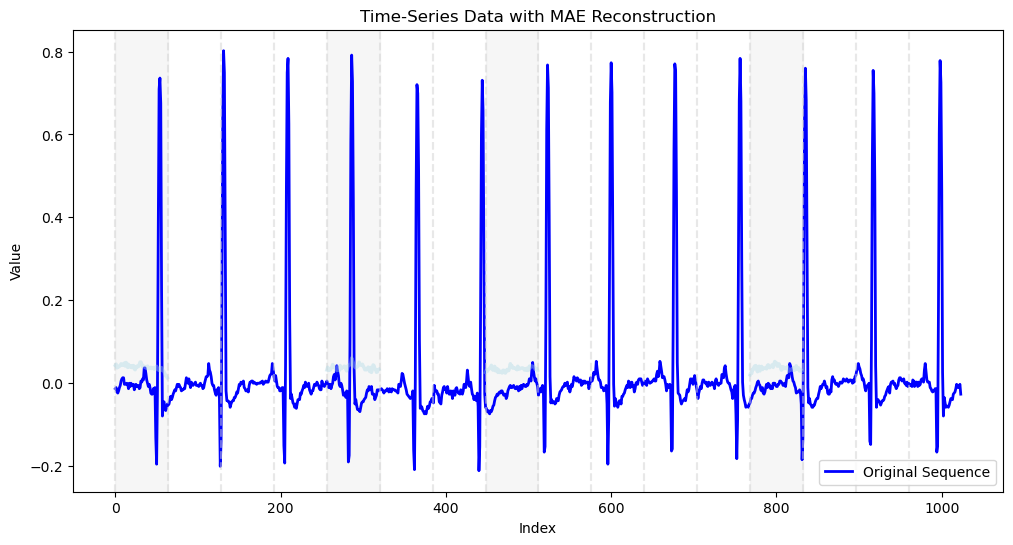

Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:54<00:00,  1.01it/s, avg_loss=0.00298]

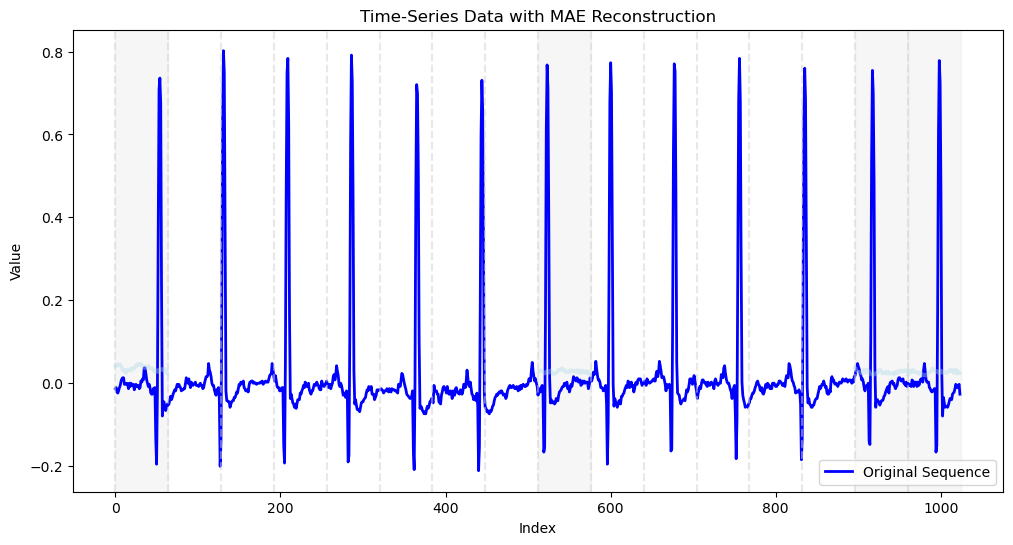

Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [04:16<00:00,  1.25s/it, avg_loss=0.00295]

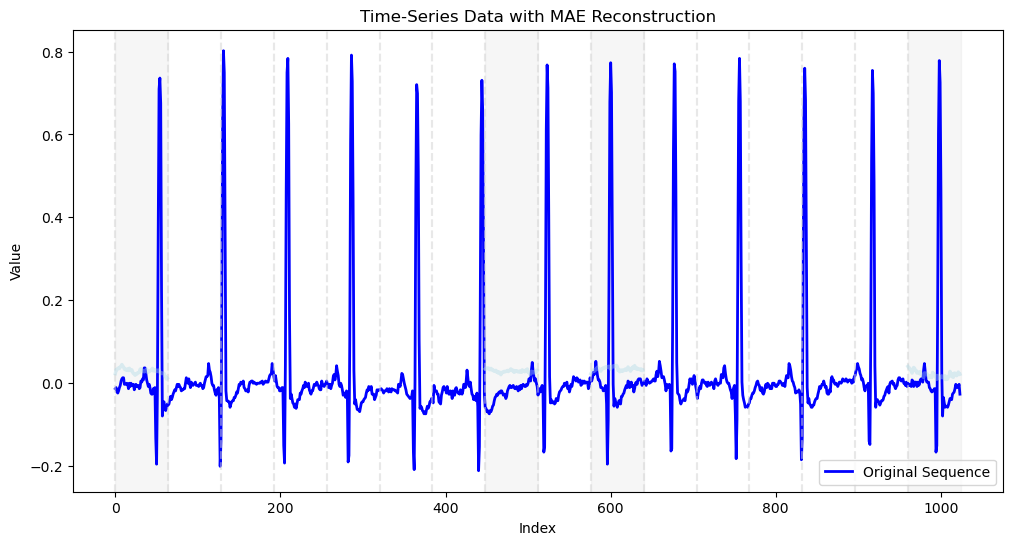

Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [06:53<00:00,  1.51s/it, avg_loss=0.00299]

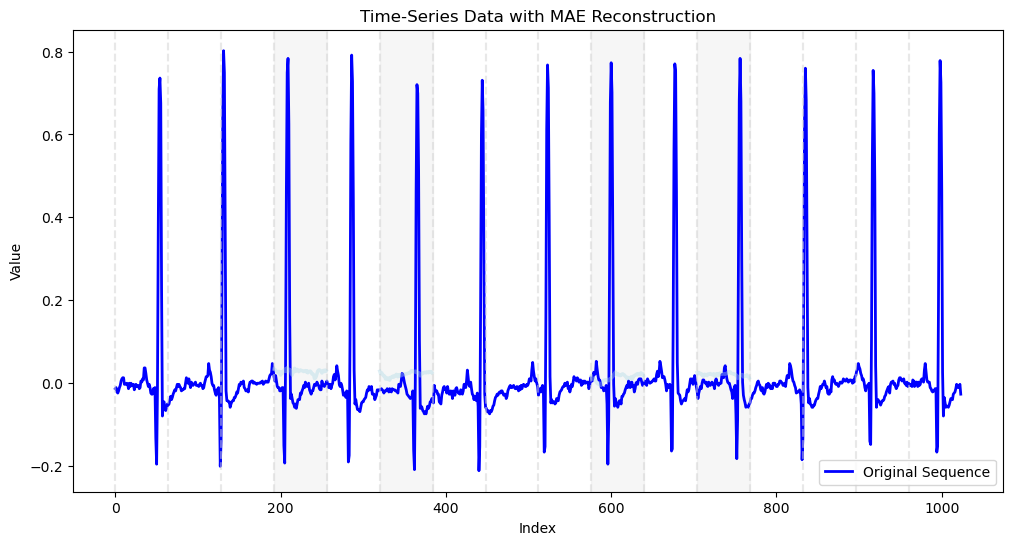

Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [1:51:35<00:00,  2.85s/it, avg_loss=0.003]

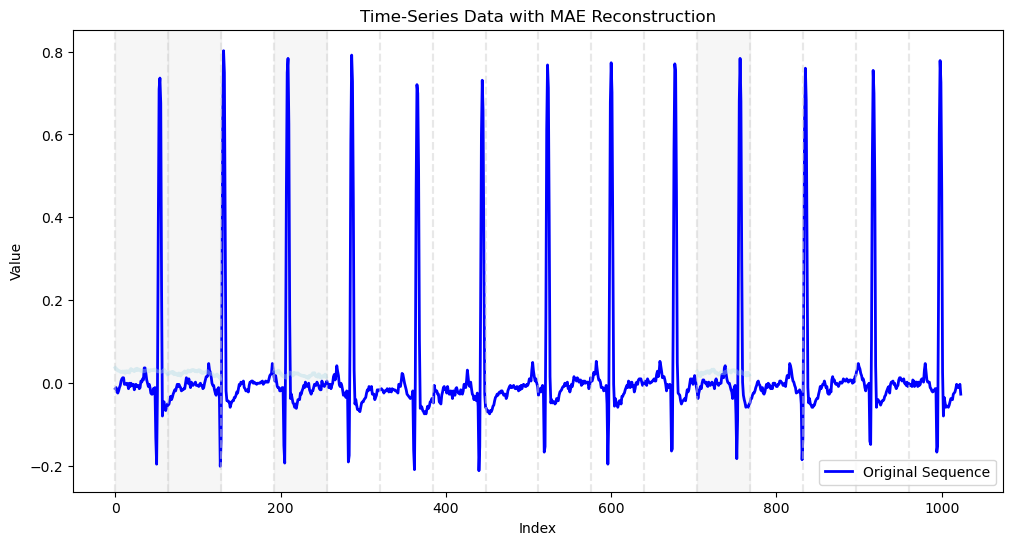

Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [1:52:08<00:00,  2.54s/it, avg_loss=0.00306]

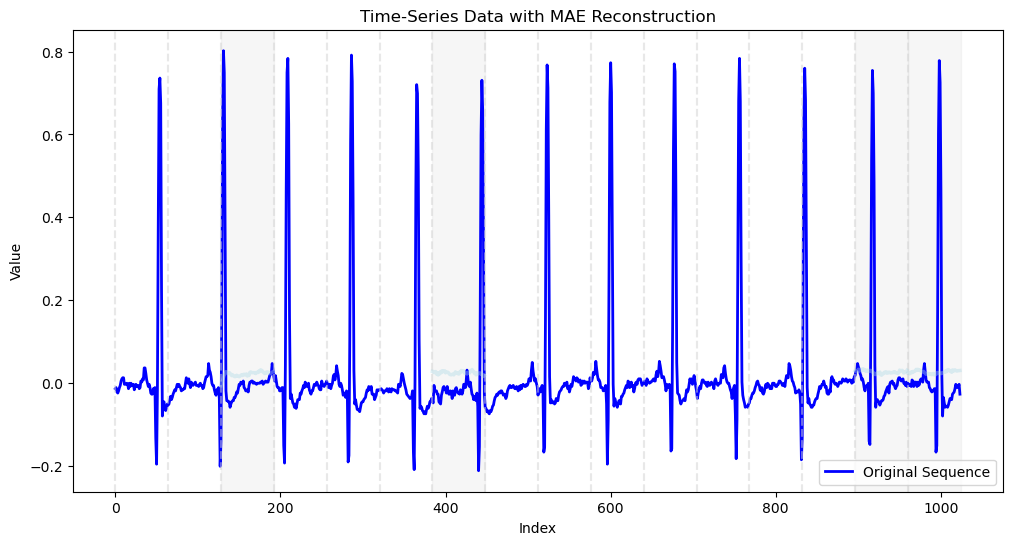

Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [55:45<00:00, 16.11s/it, avg_loss=0.0029]

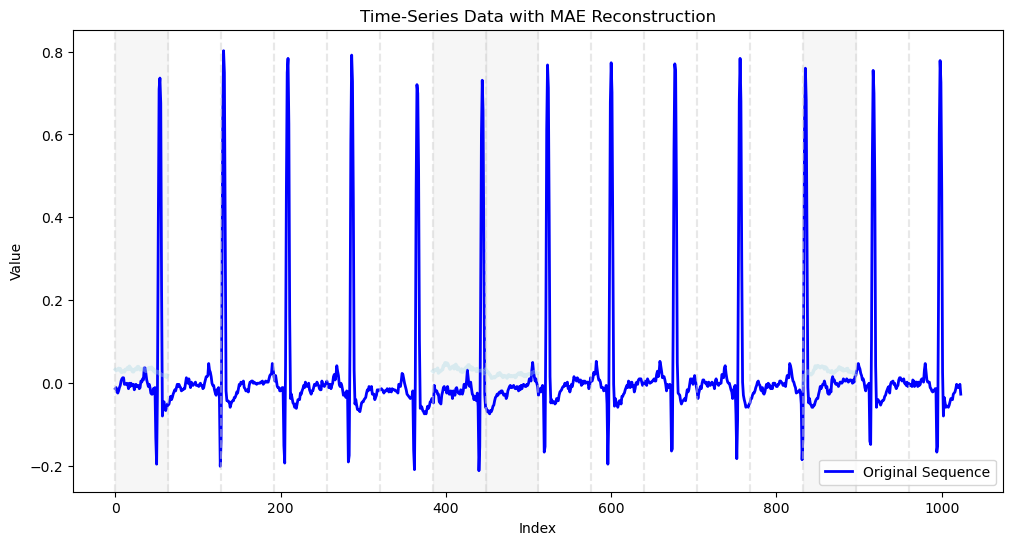

Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [30:39<00:00,  2.84s/it, avg_loss=0.0031]

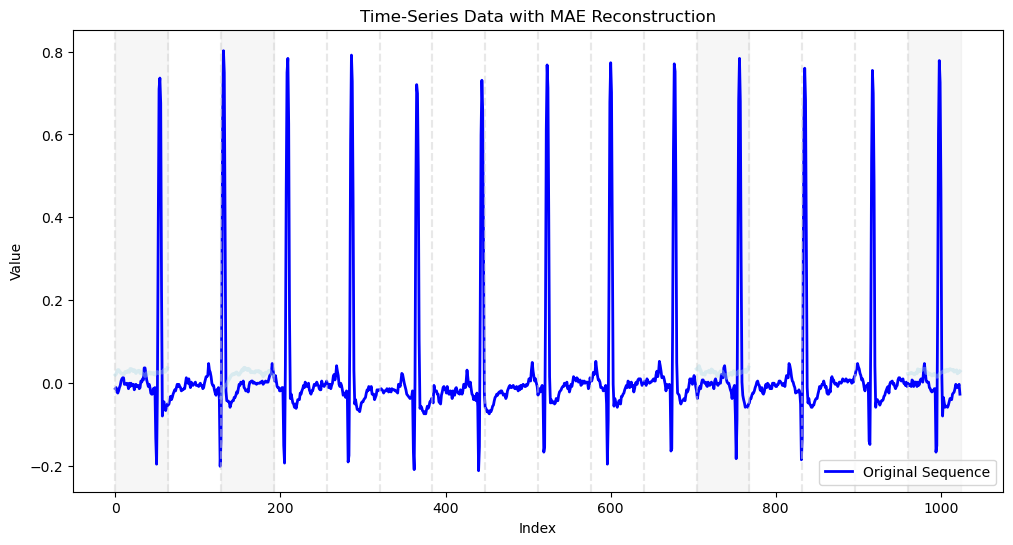

Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [30:26<00:00,  2.11s/it, avg_loss=0.00309]

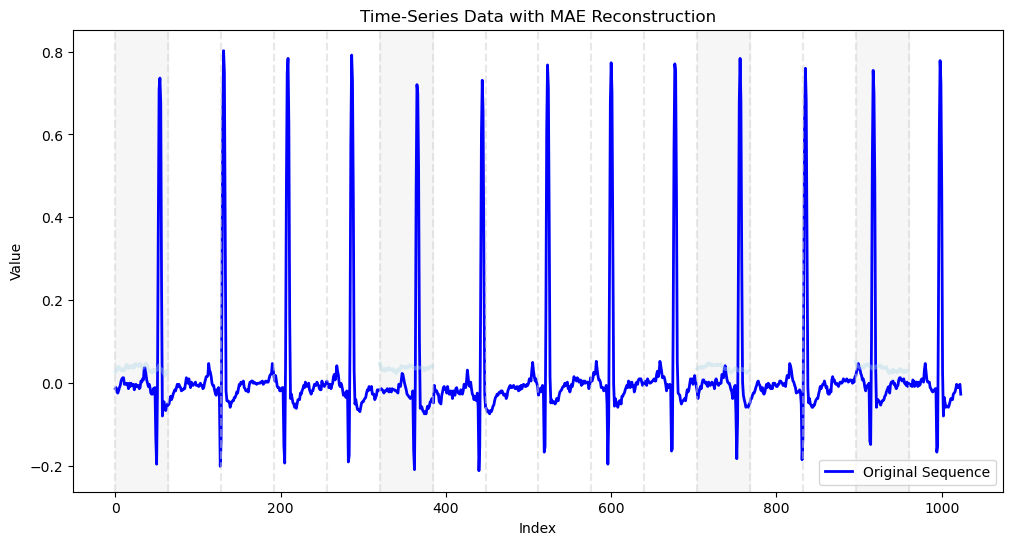

Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [29:51<00:00,  5.09s/it, avg_loss=0.00294]

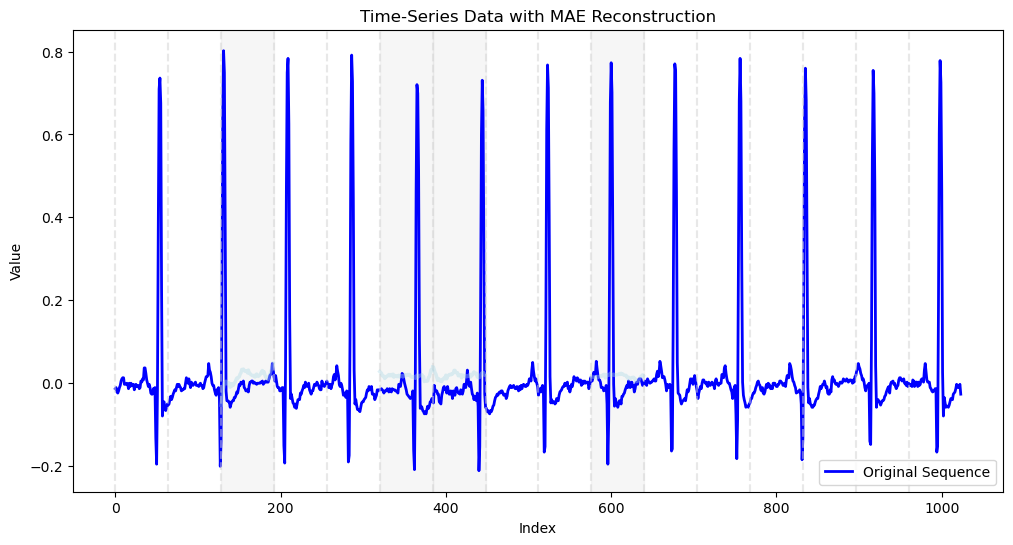

Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [45:34<00:00, 11.21s/it, avg_loss=0.00293]

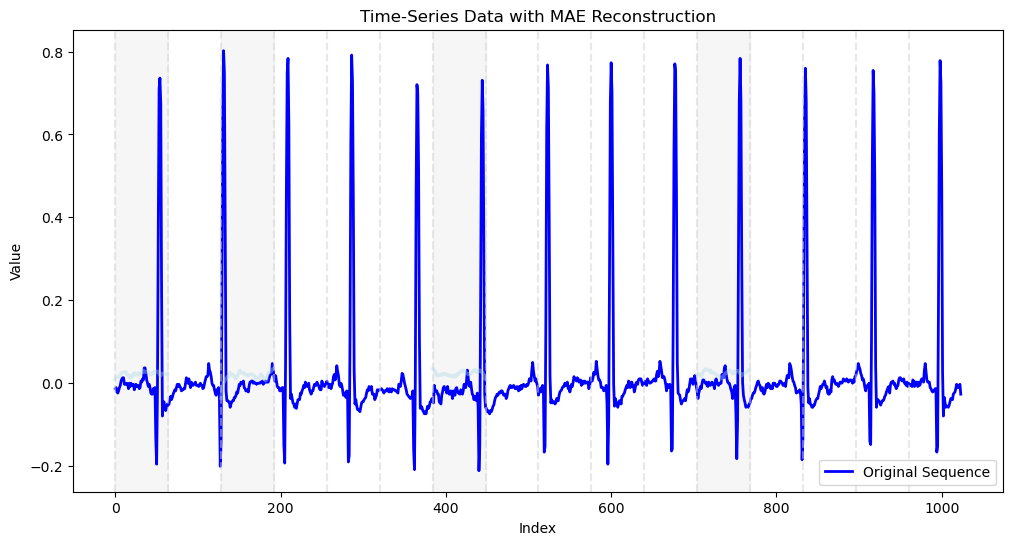

Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [42:10<00:00, 28.56s/it, avg_loss=0.00284]

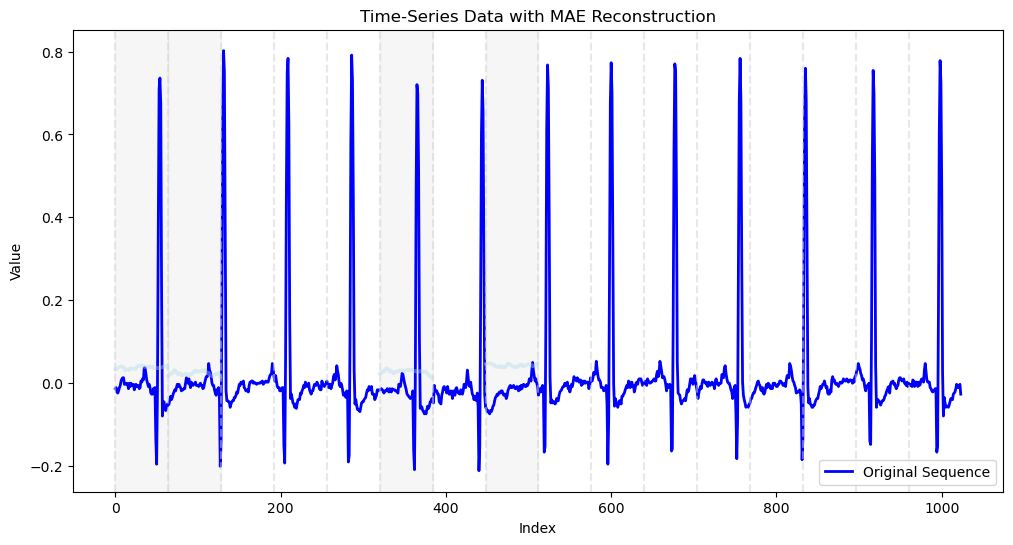

Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [45:36<00:00,  1.93s/it, avg_loss=0.00289]

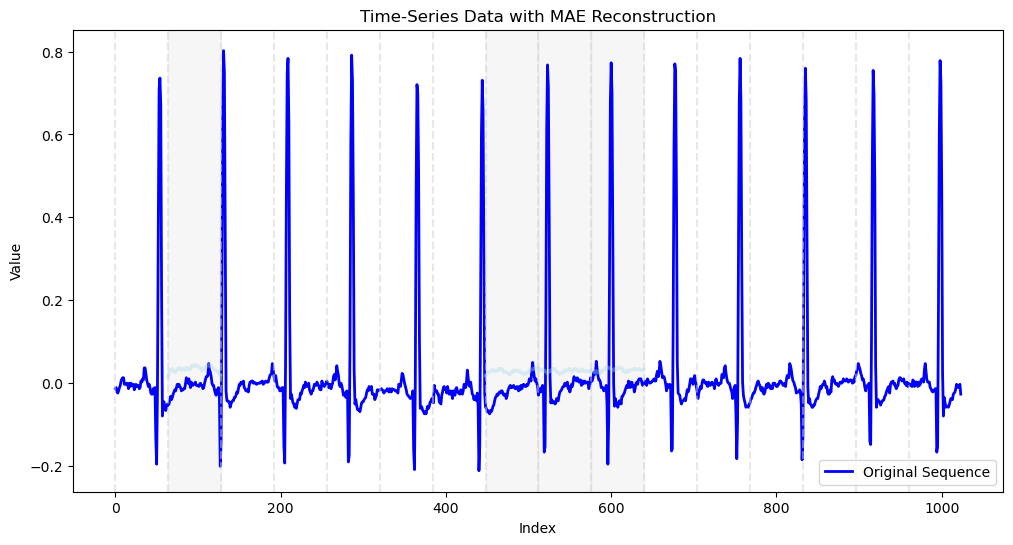

Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [24:24<00:00,  2.16s/it, avg_loss=0.00283]

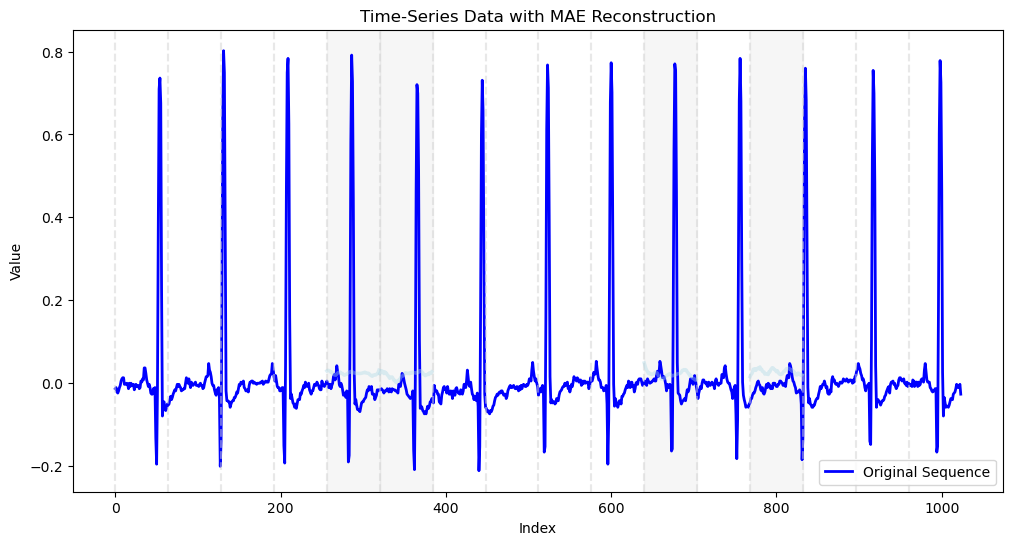

Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [52:45<00:00,  1.66s/it, avg_loss=0.00295]

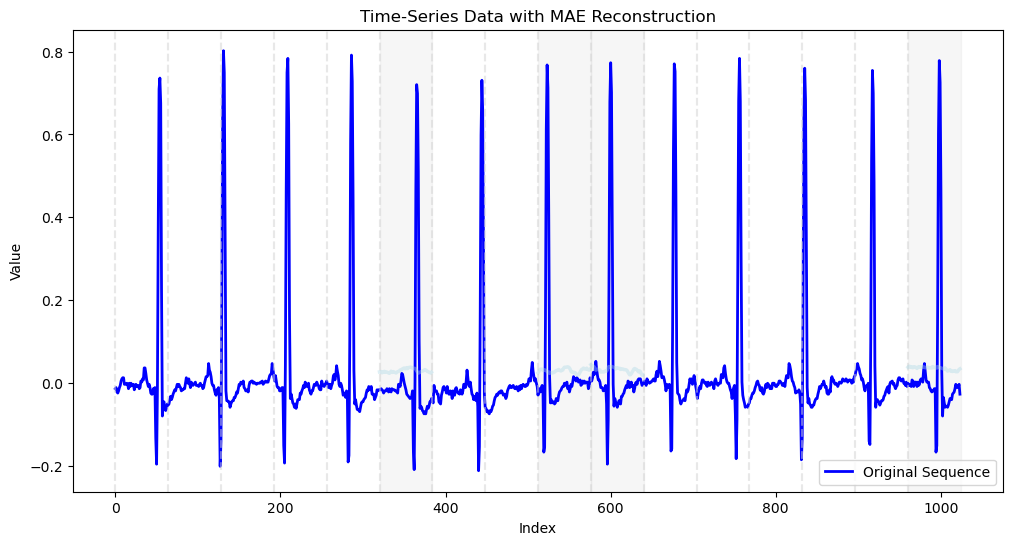

Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [2:28:00<00:00, 41.19s/it, avg_loss=0.00282]

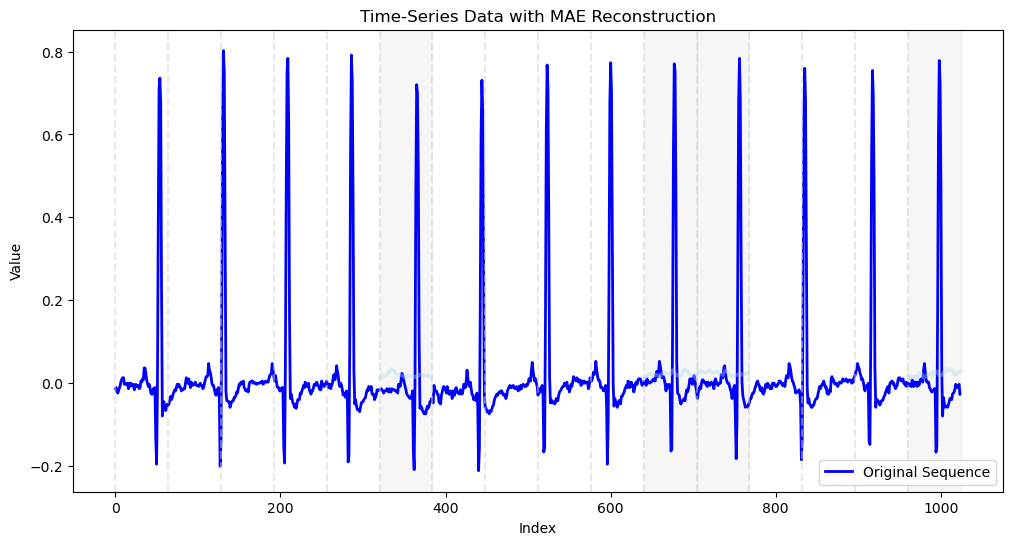

Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [1:09:20<00:00, 32.64s/it, avg_loss=0.00292]

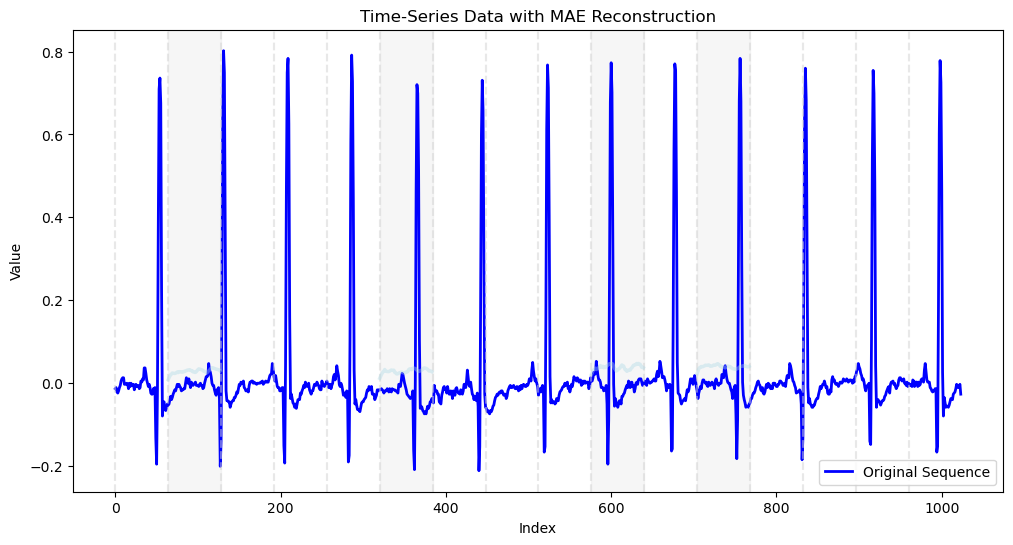

Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [38:38<00:00,  7.68s/it, avg_loss=0.00279]

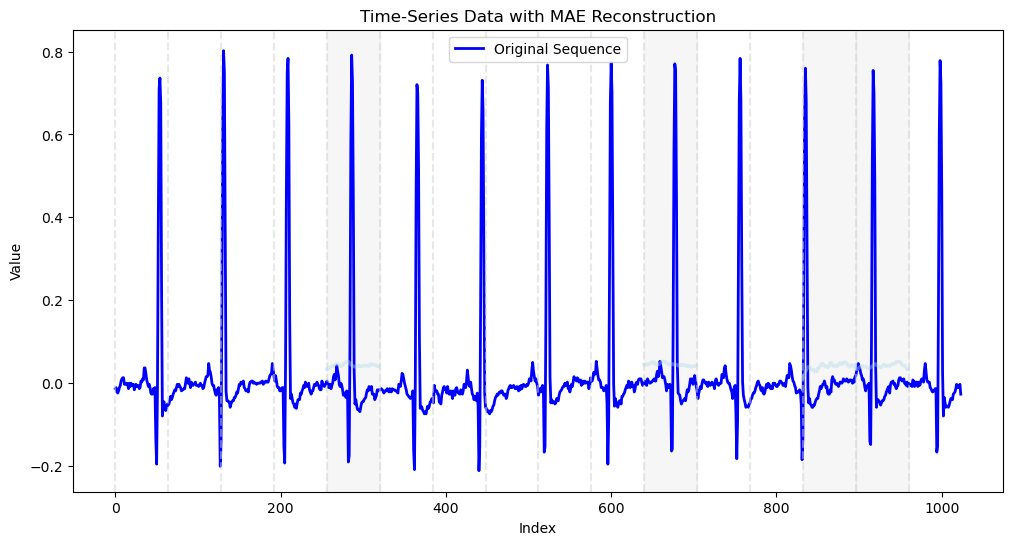

Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [26:00<00:00,  1.33s/it, avg_loss=0.00276]

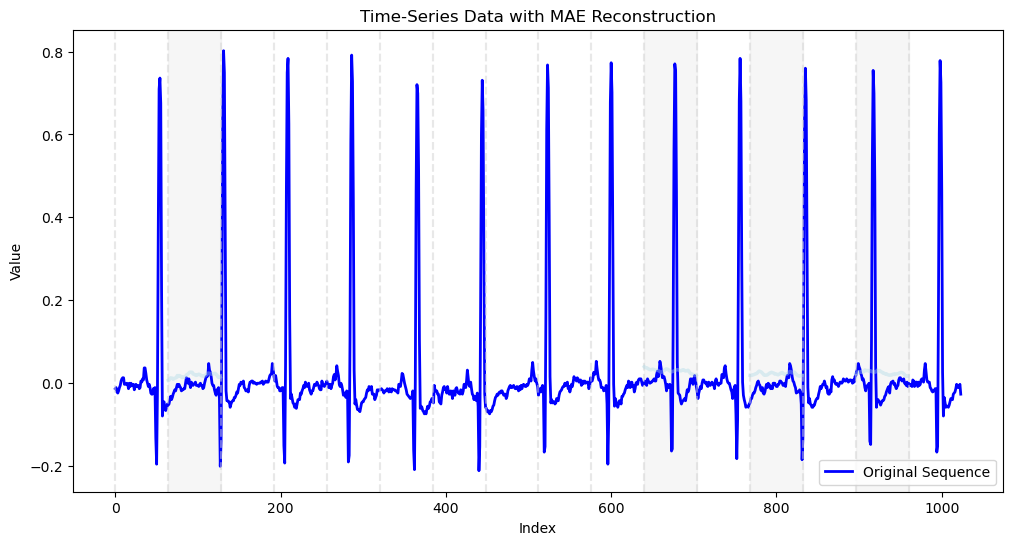

Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [25:46<00:00,  2.10s/it, avg_loss=0.00278]

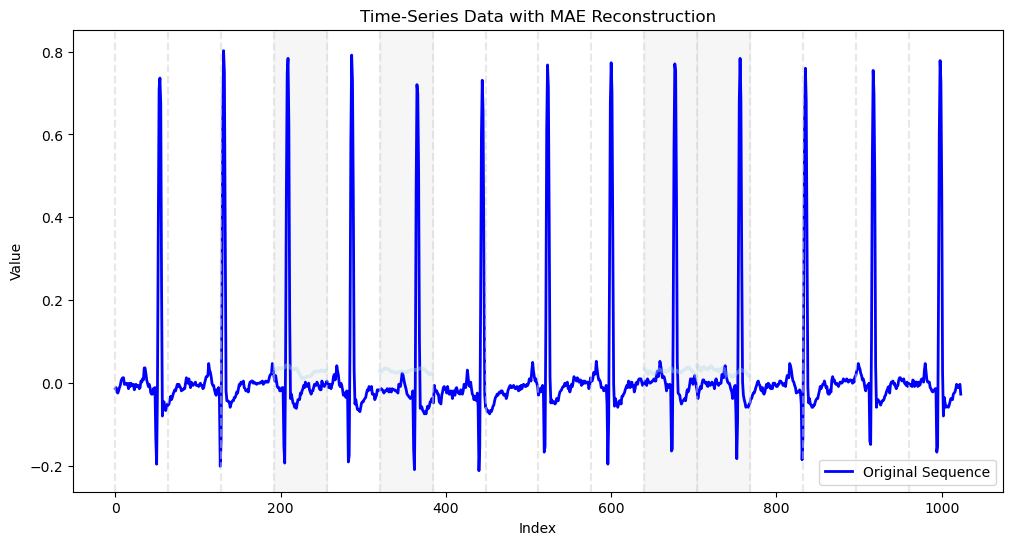

Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [2:41:14<00:00,  1.98s/it, avg_loss=0.00276]

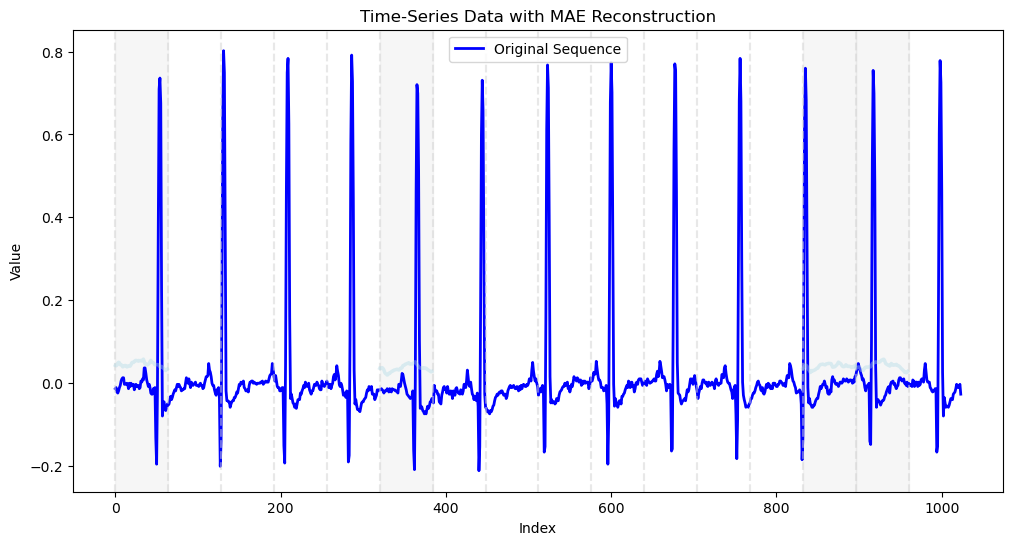

Epoch 50/50:  24%|██████████████████████████████████▋                                                                                                              | 54/226 [07:44<07:07,  2.48s/it, avg_loss=0.00281]

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(mae.parameters(), lr=learning_rate)
train_model(ecg_t, ecg_v, batch_size=32, num_epochs=50, model=mae, optimizer=optimizer)

In [29]:
with torch.no_grad():
    loss_t, patches_t, masked_indices_t, pred_pixel_values_t = mae(ecg_t[:100])
    loss_v, patches_v, masked_indices_v, pred_pixel_values_v = mae(ecg_v)

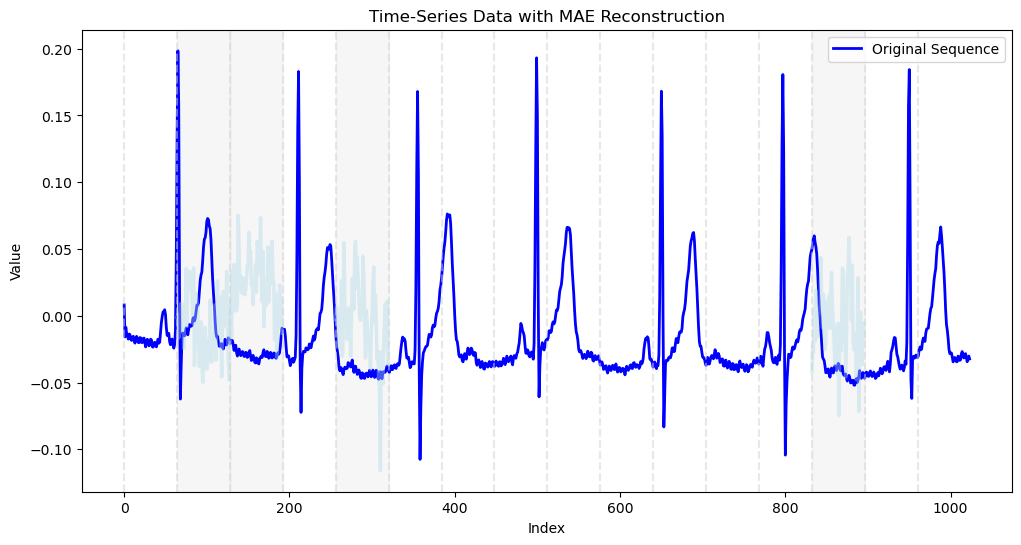

In [30]:
plot_example(patches_t, masked_indices_t, pred_pixel_values_t, 0)

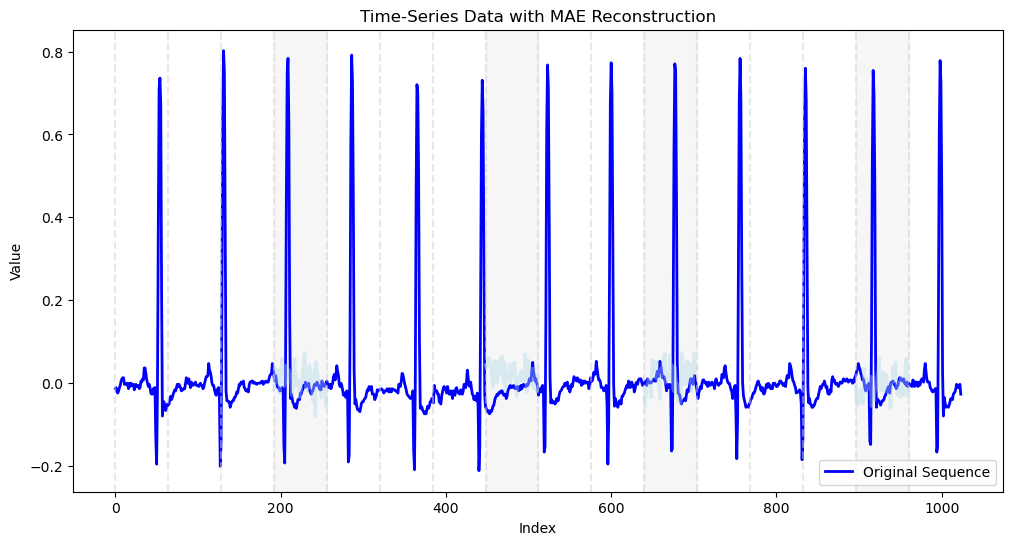

In [31]:
plot_example(patches_v, masked_indices_v, pred_pixel_values_v, 0)

In [32]:
mae.encoder

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) -> b h (p1 c)', p1=64)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=960, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=320, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64,

In [33]:
emb_ex = v.to_patch_embedding(ecg_v)
emb_ex.shape

torch.Size([1536, 16, 64])

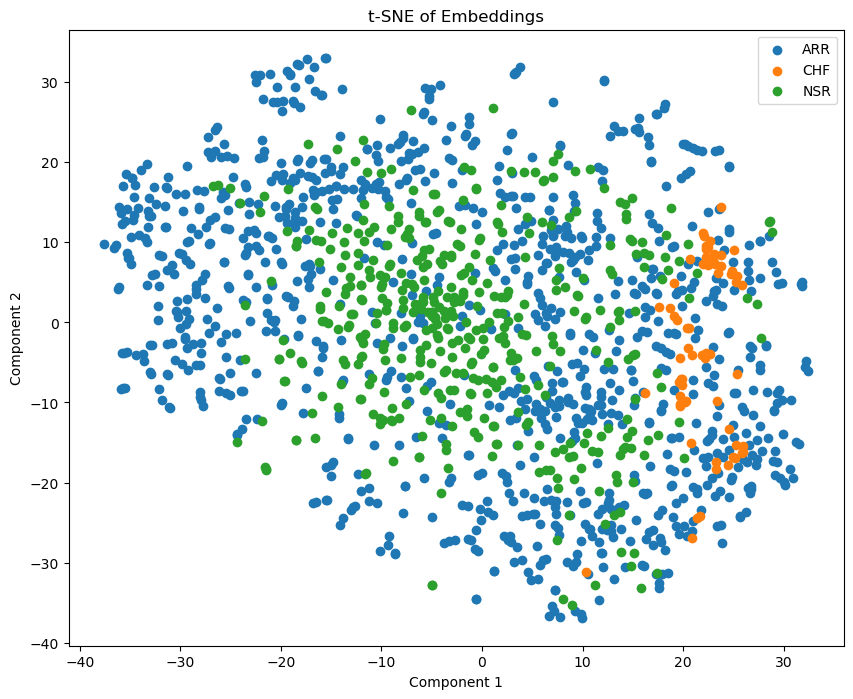

In [34]:
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming logits and labels are already defined
# Convert logits to numpy array for compatibility with scikit-learn
logits_np = emb_ex.detach().numpy().mean(axis=1)

# Flatten the nested structure of labels
labels_flattened = np.array([label[0][0] for label in labels_v])

# Encode the string labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_flattened)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
logits_2d = tsne.fit_transform(logits_np)

# Plot
plt.figure(figsize=(10, 8))

# Scatter plot for each unique label to create a legend
unique_labels = np.unique(labels_flattened)
for label in unique_labels:
    idx = labels_flattened == label
    plt.scatter(logits_2d[idx, 0], logits_2d[idx, 1], label=label)

plt.title('t-SNE of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

# CHF = congestive heart failure